In [1]:
from __future__ import print_function, division
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import data as dt
import model_1 as md
import copy
import os
from pytorch_ssim import ssim
from torch.utils.data import DataLoader
# cnn + pixelshuffle

In [2]:
# print gpu
torch.cuda.set_device(5)
currentDevice = torch.cuda.current_device()
print("Current GPU: " + str(currentDevice))
print(str(torch.cuda.device_count()))
print(str(torch.cuda.get_device_capability(currentDevice)))
print(torch.__version__)

Current GPU: 5
8
(6, 1)
1.0.0


In [3]:
USE_GPU = 1
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = "cpu"
print(device)

cuda:5


In [ ]:
# generate csv file, run only for the first time
# dt.generate_csv()

In [4]:
csvFilePath = dt.get_csv_path()
transformed_dataset = dt.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dt.Compose([                                              
                                               dt.Rescale(96),
                                               dt.Normalize(),
                                               dt.ToTensor() 
                                           ]))
# TODO: change the normalization parameters

In [14]:
# batchsize 32->16
dataloader = DataLoader(transformed_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

0 torch.Size([64, 3, 96, 96]) torch.Size([64, 96, 96])
1 torch.Size([64, 3, 96, 96]) torch.Size([64, 96, 96])
2 torch.Size([64, 3, 96, 96]) torch.Size([64, 96, 96])
3 torch.Size([64, 3, 96, 96]) torch.Size([64, 96, 96])
torch.Size([64, 1, 96, 96])


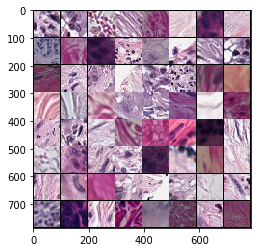

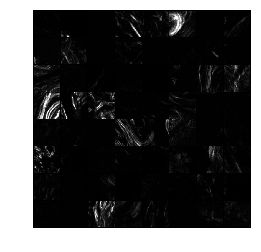

In [15]:
# TODO: insert back mean and variance to plot the image appropriately
dt.show_patch(dataloader) 

In [16]:
print('===> Building model')
model = md.Net().to(device)
criterionMSE = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)


===> Building model


In [17]:
def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].to(device), batch['output'].to(device)

        optimizer.zero_grad()
        output = model(input)
        targetf = target.float()
        targetf = targetf[:, None]
        
        lossMSE = criterionMSE(output, targetf)      
        lossSSIM = -(ssim(output, targetf)-1)
        
        p = 0.75 #0.75->0.4
        loss = p*lossMSE + (1-p)*lossSSIM
        combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
        
        epoch_loss = epoch_loss + combineLoss
        loss.backward()
        optimizer.step()
    
        if iteration%50 == 0:
            print("lossMSE: " + str(lossMSE.item()) +
                  " " + "lossSSIM: " + str(lossSSIM.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))


In [ ]:
# def test():
#     avg_psnr = 0
#     with torch.no_grad():
#         for batch in testing_data_loader:
#             input, target = batch[0].to(device), batch[1].to(device)

#             prediction = model(input)
#             mse = criterion(prediction, target)
#             psnr = 10 * log10(1 / mse.item())
#             avg_psnr += psnr
#     print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))


In [ ]:
# def checkpoint(epoch):
#     model_out_path = "model_epoch_{}.pth".format(epoch)
#     torch.save(model, model_out_path)
#     print("Checkpoint saved to {}".format(model_out_path))

In [18]:
for epoch in range(1, 10 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

lossMSE: 0.36902791261672974 lossSSIM: 1.000664472579956
===> Epoch[1](0/12672): Loss: 0.5269
lossMSE: 0.2801281213760376 lossSSIM: 0.9473780393600464
===> Epoch[1](50/12672): Loss: 0.4469
lossMSE: 0.2486717700958252 lossSSIM: 0.6847809553146362
===> Epoch[1](100/12672): Loss: 0.3577
lossMSE: 0.2125326544046402 lossSSIM: 0.6772168874740601
===> Epoch[1](150/12672): Loss: 0.3287
lossMSE: 0.1816779226064682 lossSSIM: 0.7725874185562134
===> Epoch[1](200/12672): Loss: 0.3294
lossMSE: 0.1438257098197937 lossSSIM: 0.6257893443107605
===> Epoch[1](250/12672): Loss: 0.2643
lossMSE: 0.12698078155517578 lossSSIM: 0.42640817165374756
===> Epoch[1](300/12672): Loss: 0.2018
lossMSE: 0.0959782749414444 lossSSIM: 0.5025350451469421
===> Epoch[1](350/12672): Loss: 0.1976
lossMSE: 0.08046817779541016 lossSSIM: 0.403326153755188
===> Epoch[1](400/12672): Loss: 0.1612
lossMSE: 0.06587333977222443 lossSSIM: 0.27485769987106323
===> Epoch[1](450/12672): Loss: 0.1181
lossMSE: 0.06476633995771408 lossSSIM: 

lossMSE: 0.00437145447358489 lossSSIM: 0.2755829095840454
===> Epoch[1](4150/12672): Loss: 0.0722
lossMSE: 0.012486125342547894 lossSSIM: 0.3261945843696594
===> Epoch[1](4200/12672): Loss: 0.0909
lossMSE: 0.003999077714979649 lossSSIM: 0.26611876487731934
===> Epoch[1](4250/12672): Loss: 0.0695
lossMSE: 0.009210465475916862 lossSSIM: 0.27022719383239746
===> Epoch[1](4300/12672): Loss: 0.0745
lossMSE: 0.006266294978559017 lossSSIM: 0.27557283639907837
===> Epoch[1](4350/12672): Loss: 0.0736
lossMSE: 0.015213851816952229 lossSSIM: 0.3156430721282959
===> Epoch[1](4400/12672): Loss: 0.0903
lossMSE: 0.016175562515854836 lossSSIM: 0.321272611618042
===> Epoch[1](4450/12672): Loss: 0.0924
lossMSE: 0.004305720329284668 lossSSIM: 0.2637515068054199
===> Epoch[1](4500/12672): Loss: 0.0692
lossMSE: 0.007948718033730984 lossSSIM: 0.31321609020233154
===> Epoch[1](4550/12672): Loss: 0.0843
lossMSE: 0.002884075976908207 lossSSIM: 0.24188148975372314
===> Epoch[1](4600/12672): Loss: 0.0626
lossMSE

KeyboardInterrupt: 

In [25]:
import matplotlib.pyplot as plt
from torchvision import transforms, utils
def test():
    avg_psnr = 0
    with torch.no_grad():
        for iteration, batch in enumerate(dataloader):
            input, target = batch['input'].to(device), batch['output'].to(device)
                
            prediction = model(input)

            target = target.float()

            outdataloader = {'input':prediction,'output':target}
            
            print(outdataloader['input'].size(), 
                      outdataloader['output'].size())

            plt.figure()
            input_batch, label_batch = outdataloader['input'], outdataloader['output']
            batch_size = 32
            im_size = input_batch.size(2)
            label_batch=label_batch.reshape([batch_size,1,im_size,im_size])
            print(label_batch.size())
#             for img in input_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)
                            
#             for img in label_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)                           

            grid = utils.make_grid(input).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()
            
            grid = utils.make_grid(input_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()

            grid = utils.make_grid(label_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))

            plt.axis('off')
            plt.ioff()
            plt.show()
            
            targetf = target[:, None]
            
            lossMSE = criterionMSE(prediction, targetf)      
            lossSSIM = -ssim(prediction, targetf)
        
            p = 0.4 #0.75->0.4
            loss = p*lossMSE + (1-p)*lossSSIM
            combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
#             mse = criterion(prediction, target.float())

            psnr = 10 * torch.log10(1 / loss)
            avg_psnr += psnr
            if iteration == 16:
                break
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(dataloader)))

In [22]:
def train(epoch, p, windowsize):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].to(device), batch['output'].to(device)

        optimizer.zero_grad()
        output = model(input)
        targetf = target.float()
        targetf = targetf[:, None]
        
        lossMSE = criterionMSE(output, targetf)      
        lossSSIM = 1-ssim(output, targetf, window_size=windowsize)
        
        # 0.75->0.4 after 3 epochs
        loss = p*lossMSE + (1-p)*lossSSIM
        combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
        
        epoch_loss = epoch_loss + combineLoss
        loss.backward()
        optimizer.step()
    
        if iteration%50 == 0:
            print("lossMSE: " + str(lossMSE.item()) +
                  " " + "lossSSIM: " + str(lossSSIM.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 96, 96]) torch.Size([64, 96, 96])
torch.Size([64, 1, 96, 96])


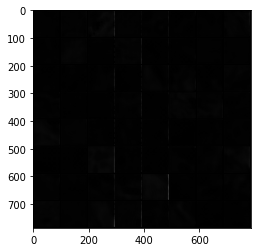

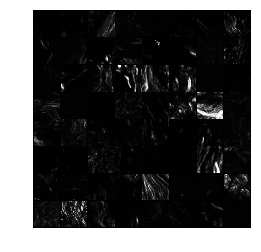

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 96, 96]) torch.Size([64, 96, 96])
torch.Size([64, 1, 96, 96])


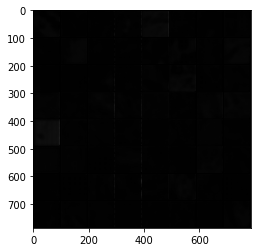

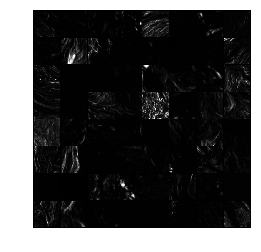

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 96, 96]) torch.Size([64, 96, 96])
torch.Size([64, 1, 96, 96])


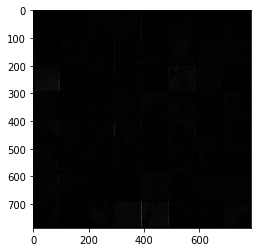

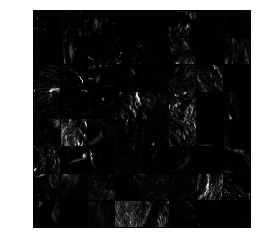

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 96, 96]) torch.Size([64, 96, 96])
torch.Size([64, 1, 96, 96])


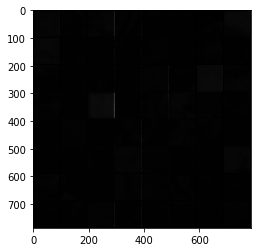

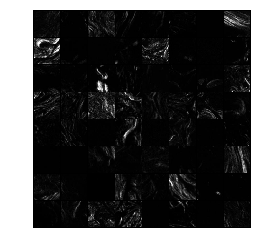

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 96, 96]) torch.Size([64, 96, 96])
torch.Size([64, 1, 96, 96])


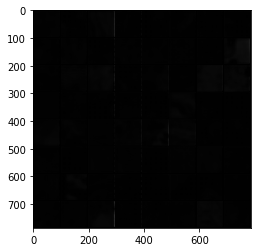

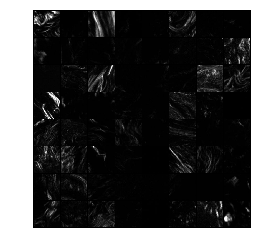

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 96, 96]) torch.Size([64, 96, 96])
torch.Size([64, 1, 96, 96])


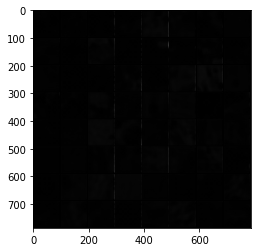

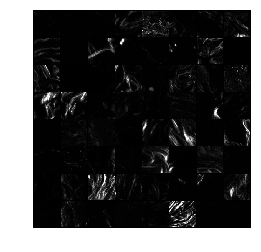

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 96, 96]) torch.Size([64, 96, 96])
torch.Size([64, 1, 96, 96])


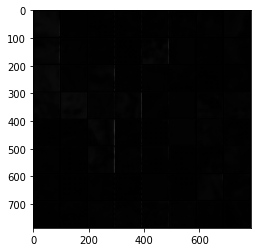

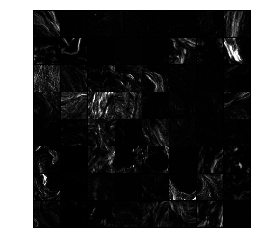

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 96, 96]) torch.Size([64, 96, 96])
torch.Size([64, 1, 96, 96])


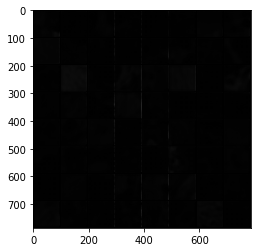

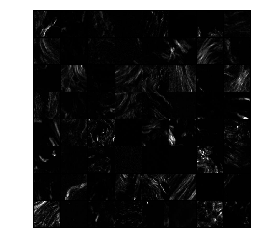

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 96, 96]) torch.Size([64, 96, 96])
torch.Size([64, 1, 96, 96])


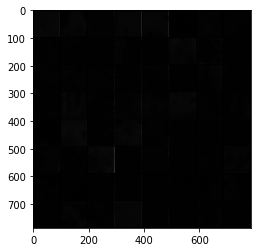

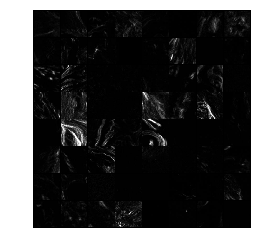

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 96, 96]) torch.Size([64, 96, 96])
torch.Size([64, 1, 96, 96])


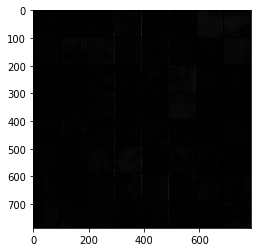

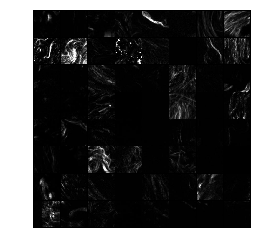

torch.Size([64, 1, 96, 96]) torch.Size([64, 96, 96])
torch.Size([64, 1, 96, 96])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


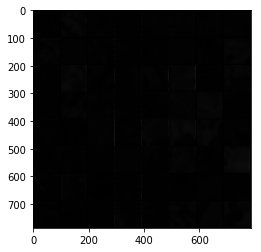

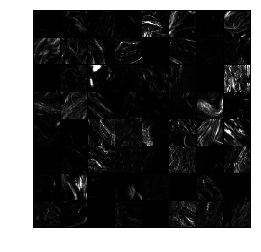

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 96, 96]) torch.Size([64, 96, 96])
torch.Size([64, 1, 96, 96])


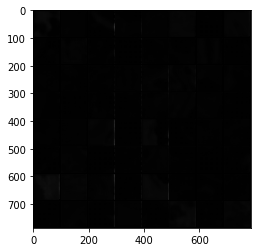

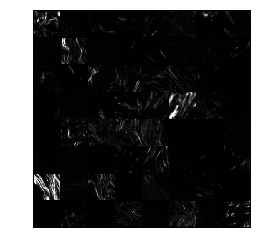

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 96, 96]) torch.Size([64, 96, 96])
torch.Size([64, 1, 96, 96])


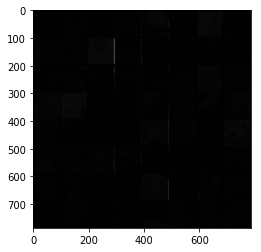

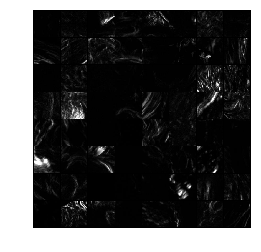

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 96, 96]) torch.Size([64, 96, 96])
torch.Size([64, 1, 96, 96])


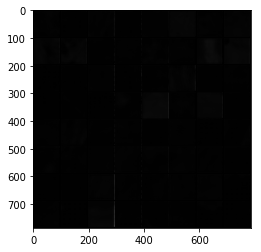

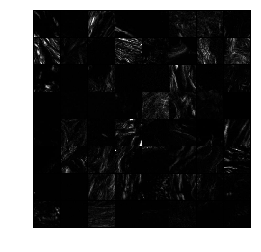

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 96, 96]) torch.Size([64, 96, 96])
torch.Size([64, 1, 96, 96])


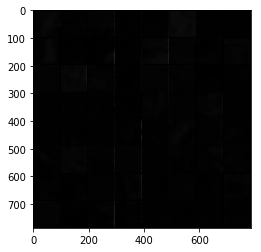

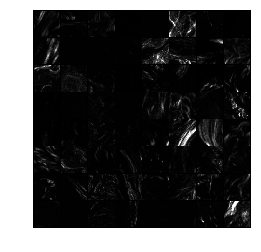

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 96, 96]) torch.Size([64, 96, 96])
torch.Size([64, 1, 96, 96])


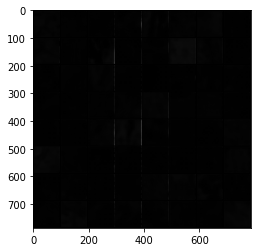

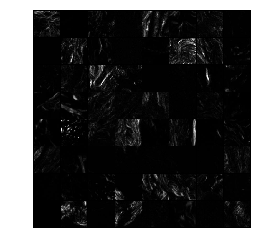

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 96, 96]) torch.Size([64, 96, 96])
torch.Size([64, 1, 96, 96])


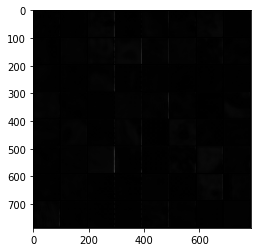

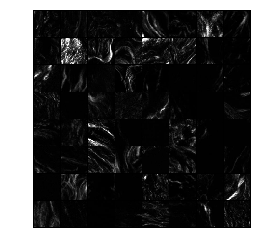

===> Avg. PSNR: nan dB


In [20]:
test()

In [ ]:
l = 0.0001
p = 0.5
windowsize = 3
for epoch in range(1, 20 + 1):
    if epoch%2 == 0:
        windowsize = windowsize+1
        p = p*0.8
        l = l*0.5
        if windowsize == 0:
            windowsze = 1
    optimizer = optim.Adam(model.parameters(), lr=l)
        
    train(epoch, p, windowsize)

lossMSE: 0.0032460077200084925 lossSSIM: 0.2574377655982971
===> Epoch[1](0/25343): Loss: 0.1303
lossMSE: 0.00550574017688632 lossSSIM: 0.25576508045196533
===> Epoch[1](50/25343): Loss: 0.1306
lossMSE: 0.005475818179547787 lossSSIM: 0.2489856481552124
===> Epoch[1](100/25343): Loss: 0.1272
lossMSE: 0.004604877904057503 lossSSIM: 0.2858436703681946
===> Epoch[1](150/25343): Loss: 0.1452
lossMSE: 0.013005092740058899 lossSSIM: 0.2893388271331787
===> Epoch[1](200/25343): Loss: 0.1512
lossMSE: 0.014737584628164768 lossSSIM: 0.280656635761261
===> Epoch[1](250/25343): Loss: 0.1477
lossMSE: 0.007057782728224993 lossSSIM: 0.26854759454727173
===> Epoch[1](300/25343): Loss: 0.1378
lossMSE: 0.014398223720490932 lossSSIM: 0.30516862869262695
===> Epoch[1](350/25343): Loss: 0.1598
lossMSE: 0.011220589280128479 lossSSIM: 0.28993380069732666
===> Epoch[1](400/25343): Loss: 0.1506
lossMSE: 0.0056555066257715225 lossSSIM: 0.2313215136528015
===> Epoch[1](450/25343): Loss: 0.1185
lossMSE: 0.00721224

lossMSE: 0.013035465963184834 lossSSIM: 0.3269796371459961
===> Epoch[1](4150/25343): Loss: 0.1700
lossMSE: 0.011961715295910835 lossSSIM: 0.2518656253814697
===> Epoch[1](4200/25343): Loss: 0.1319
lossMSE: 0.008977148681879044 lossSSIM: 0.3380388617515564
===> Epoch[1](4250/25343): Loss: 0.1735
lossMSE: 0.008629163727164268 lossSSIM: 0.27526354789733887
===> Epoch[1](4300/25343): Loss: 0.1419
lossMSE: 0.009891258552670479 lossSSIM: 0.29902368783950806
===> Epoch[1](4350/25343): Loss: 0.1545
lossMSE: 0.005452101118862629 lossSSIM: 0.2191980481147766
===> Epoch[1](4400/25343): Loss: 0.1123
lossMSE: 0.009146413765847683 lossSSIM: 0.2847962975502014
===> Epoch[1](4450/25343): Loss: 0.1470
lossMSE: 0.01066191028803587 lossSSIM: 0.2848445773124695
===> Epoch[1](4500/25343): Loss: 0.1478
lossMSE: 0.0027821743860840797 lossSSIM: 0.22832787036895752
===> Epoch[1](4550/25343): Loss: 0.1156
lossMSE: 0.0058306134305894375 lossSSIM: 0.2671715021133423
===> Epoch[1](4600/25343): Loss: 0.1365
lossMS

lossMSE: 0.007155277766287327 lossSSIM: 0.24340641498565674
===> Epoch[1](8300/25343): Loss: 0.1253
lossMSE: 0.005157794337719679 lossSSIM: 0.2422257661819458
===> Epoch[1](8350/25343): Loss: 0.1237
lossMSE: 0.001516807358711958 lossSSIM: 0.21536707878112793
===> Epoch[1](8400/25343): Loss: 0.1084
lossMSE: 0.01540832407772541 lossSSIM: 0.30932527780532837
===> Epoch[1](8450/25343): Loss: 0.1624
lossMSE: 0.003748978953808546 lossSSIM: 0.2395472526550293
===> Epoch[1](8500/25343): Loss: 0.1216
lossMSE: 0.006775234825909138 lossSSIM: 0.27842432260513306
===> Epoch[1](8550/25343): Loss: 0.1426
lossMSE: 0.00615063076838851 lossSSIM: 0.25672775506973267
===> Epoch[1](8600/25343): Loss: 0.1314
lossMSE: 0.015644004568457603 lossSSIM: 0.30797672271728516
===> Epoch[1](8650/25343): Loss: 0.1618
lossMSE: 0.00575215695425868 lossSSIM: 0.24439221620559692
===> Epoch[1](8700/25343): Loss: 0.1251
lossMSE: 0.006080157123506069 lossSSIM: 0.2618238925933838
===> Epoch[1](8750/25343): Loss: 0.1340
lossMS

lossMSE: 0.007093510590493679 lossSSIM: 0.25351613759994507
===> Epoch[1](12400/25343): Loss: 0.1303
lossMSE: 0.0107496939599514 lossSSIM: 0.27409231662750244
===> Epoch[1](12450/25343): Loss: 0.1424
lossMSE: 0.01288785319775343 lossSSIM: 0.2044782042503357
===> Epoch[1](12500/25343): Loss: 0.1087
lossMSE: 0.007317068055272102 lossSSIM: 0.27171987295150757
===> Epoch[1](12550/25343): Loss: 0.1395
lossMSE: 0.007887358777225018 lossSSIM: 0.22226166725158691
===> Epoch[1](12600/25343): Loss: 0.1151
lossMSE: 0.006338636856526136 lossSSIM: 0.2842786908149719
===> Epoch[1](12650/25343): Loss: 0.1453
lossMSE: 0.0017931631300598383 lossSSIM: 0.20586305856704712
===> Epoch[1](12700/25343): Loss: 0.1038
lossMSE: 0.008213106542825699 lossSSIM: 0.2994384765625
===> Epoch[1](12750/25343): Loss: 0.1538
lossMSE: 0.005934973247349262 lossSSIM: 0.27015817165374756
===> Epoch[1](12800/25343): Loss: 0.1380
lossMSE: 0.0031021733302623034 lossSSIM: 0.2093483805656433
===> Epoch[1](12850/25343): Loss: 0.106

lossMSE: 0.004272427875548601 lossSSIM: 0.23930901288986206
===> Epoch[1](16500/25343): Loss: 0.1218
lossMSE: 0.007062805816531181 lossSSIM: 0.26265257596969604
===> Epoch[1](16550/25343): Loss: 0.1349
lossMSE: 0.008499357849359512 lossSSIM: 0.28421080112457275
===> Epoch[1](16600/25343): Loss: 0.1464
lossMSE: 0.004188176244497299 lossSSIM: 0.21575915813446045
===> Epoch[1](16650/25343): Loss: 0.1100
lossMSE: 0.0066169556230306625 lossSSIM: 0.2637485861778259
===> Epoch[1](16700/25343): Loss: 0.1352
lossMSE: 0.003626291872933507 lossSSIM: 0.22073346376419067
===> Epoch[1](16750/25343): Loss: 0.1122
lossMSE: 0.008826169185340405 lossSSIM: 0.2943510413169861
===> Epoch[1](16800/25343): Loss: 0.1516
lossMSE: 0.004694551229476929 lossSSIM: 0.2390093207359314
===> Epoch[1](16850/25343): Loss: 0.1219
lossMSE: 0.006667901296168566 lossSSIM: 0.27228808403015137
===> Epoch[1](16900/25343): Loss: 0.1395
lossMSE: 0.005848307628184557 lossSSIM: 0.2860172390937805
===> Epoch[1](16950/25343): Loss: 

lossMSE: 0.0073844194412231445 lossSSIM: 0.26998013257980347
===> Epoch[1](20600/25343): Loss: 0.1387
lossMSE: 0.004264459013938904 lossSSIM: 0.24687999486923218
===> Epoch[1](20650/25343): Loss: 0.1256
lossMSE: 0.010319828055799007 lossSSIM: 0.35805022716522217
===> Epoch[1](20700/25343): Loss: 0.1842
lossMSE: 0.007971791550517082 lossSSIM: 0.23306763172149658
===> Epoch[1](20750/25343): Loss: 0.1205
lossMSE: 0.019490856677293777 lossSSIM: 0.31687241792678833
===> Epoch[1](20800/25343): Loss: 0.1682
lossMSE: 0.010047429241240025 lossSSIM: 0.24564921855926514
===> Epoch[1](20850/25343): Loss: 0.1278
lossMSE: 0.007217511534690857 lossSSIM: 0.2849300503730774
===> Epoch[1](20900/25343): Loss: 0.1461
lossMSE: 0.006962317507714033 lossSSIM: 0.29323697090148926
===> Epoch[1](20950/25343): Loss: 0.1501
lossMSE: 0.007078983820974827 lossSSIM: 0.2629605531692505
===> Epoch[1](21000/25343): Loss: 0.1350
lossMSE: 0.005898505449295044 lossSSIM: 0.2302563190460205
===> Epoch[1](21050/25343): Loss:

lossMSE: 0.005329112056642771 lossSSIM: 0.25688260793685913
===> Epoch[1](24700/25343): Loss: 0.1311
lossMSE: 0.002041764557361603 lossSSIM: 0.20912814140319824
===> Epoch[1](24750/25343): Loss: 0.1056
lossMSE: 0.006915917154401541 lossSSIM: 0.23169630765914917
===> Epoch[1](24800/25343): Loss: 0.1193
lossMSE: 0.004734836518764496 lossSSIM: 0.23820632696151733
===> Epoch[1](24850/25343): Loss: 0.1215
lossMSE: 0.012363661080598831 lossSSIM: 0.3143104314804077
===> Epoch[1](24900/25343): Loss: 0.1633
lossMSE: 0.004761895164847374 lossSSIM: 0.22280627489089966
===> Epoch[1](24950/25343): Loss: 0.1138
lossMSE: 0.009930234402418137 lossSSIM: 0.2995065450668335
===> Epoch[1](25000/25343): Loss: 0.1547
lossMSE: 0.005404068157076836 lossSSIM: 0.29478681087493896
===> Epoch[1](25050/25343): Loss: 0.1501
lossMSE: 0.006952935829758644 lossSSIM: 0.2642453908920288
===> Epoch[1](25100/25343): Loss: 0.1356
lossMSE: 0.004220122937113047 lossSSIM: 0.26330840587615967
===> Epoch[1](25150/25343): Loss: 

lossMSE: 0.003354694927111268 lossSSIM: 0.2604981064796448
===> Epoch[2](3450/25343): Loss: 0.1576
lossMSE: 0.015407268889248371 lossSSIM: 0.30774468183517456
===> Epoch[2](3500/25343): Loss: 0.1908
lossMSE: 0.006731072440743446 lossSSIM: 0.27909690141677856
===> Epoch[2](3550/25343): Loss: 0.1702
lossMSE: 0.004358692094683647 lossSSIM: 0.23136186599731445
===> Epoch[2](3600/25343): Loss: 0.1406
lossMSE: 0.007709963247179985 lossSSIM: 0.27731114625930786
===> Epoch[2](3650/25343): Loss: 0.1695
lossMSE: 0.012078016996383667 lossSSIM: 0.29557889699935913
===> Epoch[2](3700/25343): Loss: 0.1822
lossMSE: 0.009807496331632137 lossSSIM: 0.29806631803512573
===> Epoch[2](3750/25343): Loss: 0.1828
lossMSE: 0.003846695413812995 lossSSIM: 0.25133734941482544
===> Epoch[2](3800/25343): Loss: 0.1523
lossMSE: 0.0035161019768565893 lossSSIM: 0.20184779167175293
===> Epoch[2](3850/25343): Loss: 0.1225
lossMSE: 0.007484503090381622 lossSSIM: 0.29680705070495605
===> Epoch[2](3900/25343): Loss: 0.1811


lossMSE: 0.004903680644929409 lossSSIM: 0.2850812077522278
===> Epoch[2](7600/25343): Loss: 0.1730
lossMSE: 0.010572993196547031 lossSSIM: 0.2928735017776489
===> Epoch[2](7650/25343): Loss: 0.1800
lossMSE: 0.005746764596551657 lossSSIM: 0.22592300176620483
===> Epoch[2](7700/25343): Loss: 0.1379
lossMSE: 0.00754453893750906 lossSSIM: 0.2528652548789978
===> Epoch[2](7750/25343): Loss: 0.1547
lossMSE: 0.00562476459890604 lossSSIM: 0.30648279190063477
===> Epoch[2](7800/25343): Loss: 0.1861
lossMSE: 0.009029719978570938 lossSSIM: 0.2692173719406128
===> Epoch[2](7850/25343): Loss: 0.1651
lossMSE: 0.006839827634394169 lossSSIM: 0.3036036491394043
===> Epoch[2](7900/25343): Loss: 0.1849
lossMSE: 0.008551261387765408 lossSSIM: 0.30805790424346924
===> Epoch[2](7950/25343): Loss: 0.1883
lossMSE: 0.009414899162948132 lossSSIM: 0.28956347703933716
===> Epoch[2](8000/25343): Loss: 0.1775
lossMSE: 0.021698836237192154 lossSSIM: 0.3603566884994507
===> Epoch[2](8050/25343): Loss: 0.2249
lossMSE:

lossMSE: 0.010077246464788914 lossSSIM: 0.2950494885444641
===> Epoch[2](11750/25343): Loss: 0.1811
lossMSE: 0.003678911365568638 lossSSIM: 0.26165342330932617
===> Epoch[2](11800/25343): Loss: 0.1585
lossMSE: 0.006556979380548 lossSSIM: 0.2563111186027527
===> Epoch[2](11850/25343): Loss: 0.1564
lossMSE: 0.010905114933848381 lossSSIM: 0.31644004583358765
===> Epoch[2](11900/25343): Loss: 0.1942
lossMSE: 0.009351364336907864 lossSSIM: 0.27713465690612793
===> Epoch[2](11950/25343): Loss: 0.1700
lossMSE: 0.021599143743515015 lossSSIM: 0.3524811267852783
===> Epoch[2](12000/25343): Loss: 0.2201
lossMSE: 0.003217486897483468 lossSSIM: 0.26223230361938477
===> Epoch[2](12050/25343): Loss: 0.1586
lossMSE: 0.0076378402300179005 lossSSIM: 0.3674262762069702
===> Epoch[2](12100/25343): Loss: 0.2235
lossMSE: 0.013235501013696194 lossSSIM: 0.37563419342041016
===> Epoch[2](12150/25343): Loss: 0.2307
lossMSE: 0.008042206056416035 lossSSIM: 0.2679951786994934
===> Epoch[2](12200/25343): Loss: 0.16

lossMSE: 0.004531925544142723 lossSSIM: 0.2338407039642334
===> Epoch[2](15850/25343): Loss: 0.1421
lossMSE: 0.002301841974258423 lossSSIM: 0.2185988426208496
===> Epoch[2](15900/25343): Loss: 0.1321
lossMSE: 0.007584884762763977 lossSSIM: 0.36536961793899536
===> Epoch[2](15950/25343): Loss: 0.2223
lossMSE: 0.012055660597980022 lossSSIM: 0.2961767911911011
===> Epoch[2](16000/25343): Loss: 0.1825
lossMSE: 0.012244434095919132 lossSSIM: 0.31118643283843994
===> Epoch[2](16050/25343): Loss: 0.1916
lossMSE: 0.015114002861082554 lossSSIM: 0.29672688245773315
===> Epoch[2](16100/25343): Loss: 0.1841
lossMSE: 0.007161220069974661 lossSSIM: 0.235975980758667
===> Epoch[2](16150/25343): Loss: 0.1445
lossMSE: 0.003494696458801627 lossSSIM: 0.22480124235153198
===> Epoch[2](16200/25343): Loss: 0.1363
lossMSE: 0.009142644703388214 lossSSIM: 0.30150169134140015
===> Epoch[2](16250/25343): Loss: 0.1846
lossMSE: 0.006579801440238953 lossSSIM: 0.270613431930542
===> Epoch[2](16300/25343): Loss: 0.16

lossMSE: 0.008746319450438023 lossSSIM: 0.29883861541748047
===> Epoch[2](19950/25343): Loss: 0.1828
lossMSE: 0.008601545356214046 lossSSIM: 0.26331090927124023
===> Epoch[2](20000/25343): Loss: 0.1614
lossMSE: 0.009265333414077759 lossSSIM: 0.3182007670402527
===> Epoch[2](20050/25343): Loss: 0.1946
lossMSE: 0.0035181408748030663 lossSSIM: 0.28413861989974976
===> Epoch[2](20100/25343): Loss: 0.1719
lossMSE: 0.006612827535718679 lossSSIM: 0.28270184993743896
===> Epoch[2](20150/25343): Loss: 0.1723
lossMSE: 0.004793999250978231 lossSSIM: 0.27665650844573975
===> Epoch[2](20200/25343): Loss: 0.1679
lossMSE: 0.008099418133497238 lossSSIM: 0.249487042427063
===> Epoch[2](20250/25343): Loss: 0.1529
lossMSE: 0.004467458929866552 lossSSIM: 0.23666012287139893
===> Epoch[2](20300/25343): Loss: 0.1438
lossMSE: 0.007122899871319532 lossSSIM: 0.2842708230018616
===> Epoch[2](20350/25343): Loss: 0.1734
lossMSE: 0.009214641526341438 lossSSIM: 0.31471914052963257
===> Epoch[2](20400/25343): Loss: 

lossMSE: 0.008485822007060051 lossSSIM: 0.24272114038467407
===> Epoch[2](24050/25343): Loss: 0.1490
lossMSE: 0.006837999448180199 lossSSIM: 0.28069567680358887
===> Epoch[2](24100/25343): Loss: 0.1712
lossMSE: 0.005001867655664682 lossSSIM: 0.28064483404159546
===> Epoch[2](24150/25343): Loss: 0.1704
lossMSE: 0.00917463842779398 lossSSIM: 0.24798583984375
===> Epoch[2](24200/25343): Loss: 0.1525
lossMSE: 0.0052239117212593555 lossSSIM: 0.27889925241470337
===> Epoch[2](24250/25343): Loss: 0.1694
lossMSE: 0.008983653970062733 lossSSIM: 0.2668766975402832
===> Epoch[2](24300/25343): Loss: 0.1637
lossMSE: 0.005338374059647322 lossSSIM: 0.2732645273208618
===> Epoch[2](24350/25343): Loss: 0.1661
lossMSE: 0.0019121819641441107 lossSSIM: 0.21442937850952148
===> Epoch[2](24400/25343): Loss: 0.1294
lossMSE: 0.0019350560614839196 lossSSIM: 0.1912025809288025
===> Epoch[2](24450/25343): Loss: 0.1155
lossMSE: 0.00456516956910491 lossSSIM: 0.2713509798049927
===> Epoch[2](24500/25343): Loss: 0.1

lossMSE: 0.006692602764815092 lossSSIM: 0.27342134714126587
===> Epoch[3](2850/25343): Loss: 0.1667
lossMSE: 0.006401102524250746 lossSSIM: 0.23733991384506226
===> Epoch[3](2900/25343): Loss: 0.1450
lossMSE: 0.007605569902807474 lossSSIM: 0.2999047040939331
===> Epoch[3](2950/25343): Loss: 0.1830
lossMSE: 0.003589521162211895 lossSSIM: 0.2324492335319519
===> Epoch[3](3000/25343): Loss: 0.1409
lossMSE: 0.0076453834772109985 lossSSIM: 0.2816697955131531
===> Epoch[3](3050/25343): Loss: 0.1721
lossMSE: 0.007048165425658226 lossSSIM: 0.23287296295166016
===> Epoch[3](3100/25343): Loss: 0.1425
lossMSE: 0.007544476073235273 lossSSIM: 0.2725648283958435
===> Epoch[3](3150/25343): Loss: 0.1666
lossMSE: 0.007045118138194084 lossSSIM: 0.24919432401657104
===> Epoch[3](3200/25343): Loss: 0.1523
lossMSE: 0.00516401557251811 lossSSIM: 0.23799455165863037
===> Epoch[3](3250/25343): Loss: 0.1449
lossMSE: 0.008823651820421219 lossSSIM: 0.2872394323348999
===> Epoch[3](3300/25343): Loss: 0.1759
lossM

lossMSE: 0.005155645310878754 lossSSIM: 0.25056391954421997
===> Epoch[3](7000/25343): Loss: 0.1524
lossMSE: 0.010978332720696926 lossSSIM: 0.2894212603569031
===> Epoch[3](7050/25343): Loss: 0.1780
lossMSE: 0.00744638592004776 lossSSIM: 0.33148884773254395
===> Epoch[3](7100/25343): Loss: 0.2019
lossMSE: 0.009019598364830017 lossSSIM: 0.2741015553474426
===> Epoch[3](7150/25343): Loss: 0.1681
lossMSE: 0.006505546160042286 lossSSIM: 0.2665832042694092
===> Epoch[3](7200/25343): Loss: 0.1626
lossMSE: 0.006039859261363745 lossSSIM: 0.2849336862564087
===> Epoch[3](7250/25343): Loss: 0.1734
lossMSE: 0.004837783519178629 lossSSIM: 0.24446547031402588
===> Epoch[3](7300/25343): Loss: 0.1486
lossMSE: 0.006610146723687649 lossSSIM: 0.26659297943115234
===> Epoch[3](7350/25343): Loss: 0.1626
lossMSE: 0.0031616203486919403 lossSSIM: 0.24421393871307373
===> Epoch[3](7400/25343): Loss: 0.1478
lossMSE: 0.010263066738843918 lossSSIM: 0.27405786514282227
===> Epoch[3](7450/25343): Loss: 0.1685
loss

lossMSE: 0.013328668661415577 lossSSIM: 0.31959545612335205
===> Epoch[3](11150/25343): Loss: 0.1971
lossMSE: 0.0033966870978474617 lossSSIM: 0.24290382862091064
===> Epoch[3](11200/25343): Loss: 0.1471
lossMSE: 0.003709473880007863 lossSSIM: 0.2986719608306885
===> Epoch[3](11250/25343): Loss: 0.1807
lossMSE: 0.006795463617891073 lossSSIM: 0.2970074415206909
===> Epoch[3](11300/25343): Loss: 0.1809
lossMSE: 0.007665295619517565 lossSSIM: 0.32496124505996704
===> Epoch[3](11350/25343): Loss: 0.1980
lossMSE: 0.004304602276533842 lossSSIM: 0.21901804208755493
===> Epoch[3](11400/25343): Loss: 0.1331
lossMSE: 0.005406878888607025 lossSSIM: 0.3052387833595276
===> Epoch[3](11450/25343): Loss: 0.1853
lossMSE: 0.012836029753088951 lossSSIM: 0.26844465732574463
===> Epoch[3](11500/25343): Loss: 0.1662
lossMSE: 0.0051789842545986176 lossSSIM: 0.2763745188713074
===> Epoch[3](11550/25343): Loss: 0.1679
lossMSE: 0.011657104827463627 lossSSIM: 0.2655792832374573
===> Epoch[3](11600/25343): Loss: 

lossMSE: 0.010416191071271896 lossSSIM: 0.2691538333892822
===> Epoch[3](15250/25343): Loss: 0.1657
lossMSE: 0.0094683226197958 lossSSIM: 0.22845137119293213
===> Epoch[3](15300/25343): Loss: 0.1409
lossMSE: 0.006480115000158548 lossSSIM: 0.257279634475708
===> Epoch[3](15350/25343): Loss: 0.1570
lossMSE: 0.006577240768820047 lossSSIM: 0.27696144580841064
===> Epoch[3](15400/25343): Loss: 0.1688
lossMSE: 0.0049898638390004635 lossSSIM: 0.25868237018585205
===> Epoch[3](15450/25343): Loss: 0.1572
lossMSE: 0.01164598111063242 lossSSIM: 0.31306910514831543
===> Epoch[3](15500/25343): Loss: 0.1925
lossMSE: 0.009401153773069382 lossSSIM: 0.3246779441833496
===> Epoch[3](15550/25343): Loss: 0.1986
lossMSE: 0.006373922806233168 lossSSIM: 0.2802213430404663
===> Epoch[3](15600/25343): Loss: 0.1707
lossMSE: 0.009370896965265274 lossSSIM: 0.2340746521949768
===> Epoch[3](15650/25343): Loss: 0.1442
lossMSE: 0.004288780968636274 lossSSIM: 0.25558120012283325
===> Epoch[3](15700/25343): Loss: 0.155

lossMSE: 0.009832989424467087 lossSSIM: 0.29679012298583984
===> Epoch[3](19350/25343): Loss: 0.1820
lossMSE: 0.00590246357023716 lossSSIM: 0.2170771360397339
===> Epoch[3](19400/25343): Loss: 0.1326
lossMSE: 0.004355871118605137 lossSSIM: 0.27457576990127563
===> Epoch[3](19450/25343): Loss: 0.1665
lossMSE: 0.004533631261438131 lossSSIM: 0.23513662815093994
===> Epoch[3](19500/25343): Loss: 0.1429
lossMSE: 0.0026352261193096638 lossSSIM: 0.25499022006988525
===> Epoch[3](19550/25343): Loss: 0.1540
lossMSE: 0.003547848202288151 lossSSIM: 0.2739456295967102
===> Epoch[3](19600/25343): Loss: 0.1658
lossMSE: 0.005434755235910416 lossSSIM: 0.2795777916908264
===> Epoch[3](19650/25343): Loss: 0.1699
lossMSE: 0.008446219377219677 lossSSIM: 0.2953711748123169
===> Epoch[3](19700/25343): Loss: 0.1806
lossMSE: 0.0062506538815796375 lossSSIM: 0.2386912703514099
===> Epoch[3](19750/25343): Loss: 0.1457
lossMSE: 0.005103942938148975 lossSSIM: 0.24701672792434692
===> Epoch[3](19800/25343): Loss: 0

lossMSE: 0.008897623047232628 lossSSIM: 0.25548070669174194
===> Epoch[3](23450/25343): Loss: 0.1568
lossMSE: 0.0032098160590976477 lossSSIM: 0.2647096514701843
===> Epoch[3](23500/25343): Loss: 0.1601
lossMSE: 0.003995189443230629 lossSSIM: 0.23360025882720947
===> Epoch[3](23550/25343): Loss: 0.1418
lossMSE: 0.011175187304615974 lossSSIM: 0.27454519271850586
===> Epoch[3](23600/25343): Loss: 0.1692
lossMSE: 0.005732507910579443 lossSSIM: 0.26381194591522217
===> Epoch[3](23650/25343): Loss: 0.1606
lossMSE: 0.007449625991284847 lossSSIM: 0.29288309812545776
===> Epoch[3](23700/25343): Loss: 0.1787
lossMSE: 0.00366580649279058 lossSSIM: 0.29293370246887207
===> Epoch[3](23750/25343): Loss: 0.1772
lossMSE: 0.010782263241708279 lossSSIM: 0.2824414372444153
===> Epoch[3](23800/25343): Loss: 0.1738
lossMSE: 0.003589536063373089 lossSSIM: 0.23544609546661377
===> Epoch[3](23850/25343): Loss: 0.1427
lossMSE: 0.0028633293695747852 lossSSIM: 0.23158490657806396
===> Epoch[3](23900/25343): Loss

lossMSE: 0.0051994663663208485 lossSSIM: 0.23198449611663818
===> Epoch[4](2200/25343): Loss: 0.1594
lossMSE: 0.009389284066855907 lossSSIM: 0.3368692994117737
===> Epoch[4](2250/25343): Loss: 0.2321
lossMSE: 0.006119909230619669 lossSSIM: 0.262198269367218
===> Epoch[4](2300/25343): Loss: 0.1803
lossMSE: 0.008909186348319054 lossSSIM: 0.33515554666519165
===> Epoch[4](2350/25343): Loss: 0.2308
lossMSE: 0.009632795117795467 lossSSIM: 0.3516102433204651
===> Epoch[4](2400/25343): Loss: 0.2422
lossMSE: 0.008440437726676464 lossSSIM: 0.3213808536529541
===> Epoch[4](2450/25343): Loss: 0.2212
lossMSE: 0.00601222412660718 lossSSIM: 0.23793894052505493
===> Epoch[4](2500/25343): Loss: 0.1637
lossMSE: 0.010318094864487648 lossSSIM: 0.27678602933883667
===> Epoch[4](2550/25343): Loss: 0.1915
lossMSE: 0.0028125697281211615 lossSSIM: 0.22490888833999634
===> Epoch[4](2600/25343): Loss: 0.1538
lossMSE: 0.006290320307016373 lossSSIM: 0.3042488098144531
===> Epoch[4](2650/25343): Loss: 0.2089
lossM

lossMSE: 0.003339204005897045 lossSSIM: 0.23757606744766235
===> Epoch[4](6350/25343): Loss: 0.1626
lossMSE: 0.008143563754856586 lossSSIM: 0.27380824089050293
===> Epoch[4](6400/25343): Loss: 0.1888
lossMSE: 0.007143700961023569 lossSSIM: 0.27010971307754517
===> Epoch[4](6450/25343): Loss: 0.1860
lossMSE: 0.00973037350922823 lossSSIM: 0.3119473457336426
===> Epoch[4](6500/25343): Loss: 0.2152
lossMSE: 0.010339289903640747 lossSSIM: 0.2702562212944031
===> Epoch[4](6550/25343): Loss: 0.1871
lossMSE: 0.0025980386417359114 lossSSIM: 0.22058874368667603
===> Epoch[4](6600/25343): Loss: 0.1508
lossMSE: 0.0062804995104670525 lossSSIM: 0.29213351011276245
===> Epoch[4](6650/25343): Loss: 0.2007
lossMSE: 0.009164590388536453 lossSSIM: 0.294705867767334
===> Epoch[4](6700/25343): Loss: 0.2033
lossMSE: 0.008802891708910465 lossSSIM: 0.2751823663711548
===> Epoch[4](6750/25343): Loss: 0.1899
lossMSE: 0.013120623305439949 lossSSIM: 0.3210453391075134
===> Epoch[4](6800/25343): Loss: 0.2225
lossM

lossMSE: 0.003840784542262554 lossSSIM: 0.2308557629585266
===> Epoch[4](10500/25343): Loss: 0.1582
lossMSE: 0.00917732622474432 lossSSIM: 0.2970890402793884
===> Epoch[4](10550/25343): Loss: 0.2050
lossMSE: 0.0069738347083330154 lossSSIM: 0.3288034200668335
===> Epoch[4](10600/25343): Loss: 0.2258
lossMSE: 0.007007361389696598 lossSSIM: 0.2852744460105896
===> Epoch[4](10650/25343): Loss: 0.1962
lossMSE: 0.0057235644198954105 lossSSIM: 0.28273195028305054
===> Epoch[4](10700/25343): Loss: 0.1941
lossMSE: 0.010984325781464577 lossSSIM: 0.279927134513855
===> Epoch[4](10750/25343): Loss: 0.1939
lossMSE: 0.002135232090950012 lossSSIM: 0.2296445369720459
===> Epoch[4](10800/25343): Loss: 0.1568
lossMSE: 0.0069657317362725735 lossSSIM: 0.2289624810218811
===> Epoch[4](10850/25343): Loss: 0.1579
lossMSE: 0.01042651291936636 lossSSIM: 0.26359087228775024
===> Epoch[4](10900/25343): Loss: 0.1826
lossMSE: 0.0037995721213519573 lossSSIM: 0.22344082593917847
===> Epoch[4](10950/25343): Loss: 0.1

lossMSE: 0.006620624102652073 lossSSIM: 0.25153547525405884
===> Epoch[4](14600/25343): Loss: 0.1732
lossMSE: 0.0049150120466947556 lossSSIM: 0.2824859023094177
===> Epoch[4](14650/25343): Loss: 0.1937
lossMSE: 0.012396190315485 lossSSIM: 0.3208131790161133
===> Epoch[4](14700/25343): Loss: 0.2221
lossMSE: 0.008231308311223984 lossSSIM: 0.2676928639411926
===> Epoch[4](14750/25343): Loss: 0.1847
lossMSE: 0.005871554370969534 lossSSIM: 0.23271220922470093
===> Epoch[4](14800/25343): Loss: 0.1601
lossMSE: 0.007641342002898455 lossSSIM: 0.3188379406929016
===> Epoch[4](14850/25343): Loss: 0.2193
lossMSE: 0.008863789029419422 lossSSIM: 0.273703932762146
===> Epoch[4](14900/25343): Loss: 0.1890
lossMSE: 0.002328701550140977 lossSSIM: 0.24837887287139893
===> Epoch[4](14950/25343): Loss: 0.1696
lossMSE: 0.004578207619488239 lossSSIM: 0.24557310342788696
===> Epoch[4](15000/25343): Loss: 0.1685
lossMSE: 0.006171833723783493 lossSSIM: 0.25590598583221436
===> Epoch[4](15050/25343): Loss: 0.176

lossMSE: 0.0034378361888229847 lossSSIM: 0.23137593269348145
===> Epoch[4](18700/25343): Loss: 0.1584
lossMSE: 0.0073087941855192184 lossSSIM: 0.31935566663742065
===> Epoch[4](18750/25343): Loss: 0.2195
lossMSE: 0.005838473793119192 lossSSIM: 0.26703959703445435
===> Epoch[4](18800/25343): Loss: 0.1835
lossMSE: 0.003626790829002857 lossSSIM: 0.220140278339386
===> Epoch[4](18850/25343): Loss: 0.1509
lossMSE: 0.008111904375255108 lossSSIM: 0.2847440838813782
===> Epoch[4](18900/25343): Loss: 0.1962
lossMSE: 0.009219570085406303 lossSSIM: 0.31772106885910034
===> Epoch[4](18950/25343): Loss: 0.2190
lossMSE: 0.009652916342020035 lossSSIM: 0.325380802154541
===> Epoch[4](19000/25343): Loss: 0.2243
lossMSE: 0.0026843517553061247 lossSSIM: 0.22221946716308594
===> Epoch[4](19050/25343): Loss: 0.1520
lossMSE: 0.005244949366897345 lossSSIM: 0.24122190475463867
===> Epoch[4](19100/25343): Loss: 0.1657
lossMSE: 0.00584969948977232 lossSSIM: 0.27768272161483765
===> Epoch[4](19150/25343): Loss: 

lossMSE: 0.010241899639368057 lossSSIM: 0.32011938095092773
===> Epoch[4](22800/25343): Loss: 0.2210
lossMSE: 0.005182123742997646 lossSSIM: 0.26867133378982544
===> Epoch[4](22850/25343): Loss: 0.1844
lossMSE: 0.004093423020094633 lossSSIM: 0.24808353185653687
===> Epoch[4](22900/25343): Loss: 0.1700
lossMSE: 0.006548081990331411 lossSSIM: 0.2752779722213745
===> Epoch[4](22950/25343): Loss: 0.1893
lossMSE: 0.01474707666784525 lossSSIM: 0.3187716007232666
===> Epoch[4](23000/25343): Loss: 0.2215
lossMSE: 0.010678529739379883 lossSSIM: 0.2841854691505432
===> Epoch[4](23050/25343): Loss: 0.1967
lossMSE: 0.011649911291897297 lossSSIM: 0.36243200302124023
===> Epoch[4](23100/25343): Loss: 0.2502
lossMSE: 0.00349616352468729 lossSSIM: 0.24935394525527954
===> Epoch[4](23150/25343): Loss: 0.1707
lossMSE: 0.009858664125204086 lossSSIM: 0.30978018045425415
===> Epoch[4](23200/25343): Loss: 0.2138
lossMSE: 0.0089945700019598 lossSSIM: 0.30881619453430176
===> Epoch[4](23250/25343): Loss: 0.21

lossMSE: 0.0051622409373521805 lossSSIM: 0.2571883201599121
===> Epoch[5](1550/25343): Loss: 0.1765
lossMSE: 0.0033310975413769484 lossSSIM: 0.21345531940460205
===> Epoch[5](1600/25343): Loss: 0.1462
lossMSE: 0.005260266363620758 lossSSIM: 0.26309138536453247
===> Epoch[5](1650/25343): Loss: 0.1806
lossMSE: 0.005652063526213169 lossSSIM: 0.2503572106361389
===> Epoch[5](1700/25343): Loss: 0.1721
lossMSE: 0.01090219896286726 lossSSIM: 0.287359356880188
===> Epoch[5](1750/25343): Loss: 0.1989
lossMSE: 0.0046781268902122974 lossSSIM: 0.24533337354660034
===> Epoch[5](1800/25343): Loss: 0.1683
lossMSE: 0.010359645821154118 lossSSIM: 0.29605358839035034
===> Epoch[5](1850/25343): Loss: 0.2046
lossMSE: 0.003817470045760274 lossSSIM: 0.24709808826446533
===> Epoch[5](1900/25343): Loss: 0.1692
lossMSE: 0.002844590460881591 lossSSIM: 0.2413122057914734
===> Epoch[5](1950/25343): Loss: 0.1650
lossMSE: 0.0030062193982303143 lossSSIM: 0.24224692583084106
===> Epoch[5](2000/25343): Loss: 0.1657
lo

lossMSE: 0.007281292695552111 lossSSIM: 0.26616793870925903
===> Epoch[5](5700/25343): Loss: 0.1833
lossMSE: 0.0031093566212803125 lossSSIM: 0.27177584171295166
===> Epoch[5](5750/25343): Loss: 0.1858
lossMSE: 0.008530098013579845 lossSSIM: 0.2936815619468689
===> Epoch[5](5800/25343): Loss: 0.2024
lossMSE: 0.008181669749319553 lossSSIM: 0.26322227716445923
===> Epoch[5](5850/25343): Loss: 0.1816
lossMSE: 0.005903898738324642 lossSSIM: 0.2387218475341797
===> Epoch[5](5900/25343): Loss: 0.1642
lossMSE: 0.0026709490921348333 lossSSIM: 0.24028879404067993
===> Epoch[5](5950/25343): Loss: 0.1643
lossMSE: 0.011961263604462147 lossSSIM: 0.35954219102859497
===> Epoch[5](6000/25343): Loss: 0.2483
lossMSE: 0.010178836062550545 lossSSIM: 0.2661967873573303
===> Epoch[5](6050/25343): Loss: 0.1843
lossMSE: 0.0057238326407969 lossSSIM: 0.26418787240982056
===> Epoch[5](6100/25343): Loss: 0.1815
lossMSE: 0.011062284000217915 lossSSIM: 0.37016987800598145
===> Epoch[5](6150/25343): Loss: 0.2553
los

lossMSE: 0.0044613671489059925 lossSSIM: 0.26727205514907837
===> Epoch[5](9850/25343): Loss: 0.1832
lossMSE: 0.005475322250276804 lossSSIM: 0.2717253565788269
===> Epoch[5](9900/25343): Loss: 0.1865
lossMSE: 0.01978135108947754 lossSSIM: 0.29212063550949097
===> Epoch[5](9950/25343): Loss: 0.2050
lossMSE: 0.012592105194926262 lossSSIM: 0.2800469398498535
===> Epoch[5](10000/25343): Loss: 0.1945
lossMSE: 0.006123237311840057 lossSSIM: 0.27790236473083496
===> Epoch[5](10050/25343): Loss: 0.1909
lossMSE: 0.01128103956580162 lossSSIM: 0.324323832988739
===> Epoch[5](10100/25343): Loss: 0.2242
lossMSE: 0.0034248989541083574 lossSSIM: 0.2260187268257141
===> Epoch[5](10150/25343): Loss: 0.1548
lossMSE: 0.004137646872550249 lossSSIM: 0.24711686372756958
===> Epoch[5](10200/25343): Loss: 0.1694
lossMSE: 0.01808992214500904 lossSSIM: 0.3794838786125183
===> Epoch[5](10250/25343): Loss: 0.2638
lossMSE: 0.0024068327620625496 lossSSIM: 0.2606116533279419
===> Epoch[5](10300/25343): Loss: 0.1780


lossMSE: 0.0035361971240490675 lossSSIM: 0.29187607765197754
===> Epoch[5](13950/25343): Loss: 0.1996
lossMSE: 0.003457321086898446 lossSSIM: 0.25353771448135376
===> Epoch[5](14000/25343): Loss: 0.1735
lossMSE: 0.004630791489034891 lossSSIM: 0.26405805349349976
===> Epoch[5](14050/25343): Loss: 0.1810
lossMSE: 0.005870724096894264 lossSSIM: 0.27141356468200684
===> Epoch[5](14100/25343): Loss: 0.1864
lossMSE: 0.013179038651287556 lossSSIM: 0.26597750186920166
===> Epoch[5](14150/25343): Loss: 0.1851
lossMSE: 0.009614690206944942 lossSSIM: 0.23747247457504272
===> Epoch[5](14200/25343): Loss: 0.1646
lossMSE: 0.020083418115973473 lossSSIM: 0.2970818281173706
===> Epoch[5](14250/25343): Loss: 0.2084
lossMSE: 0.01225242204964161 lossSSIM: 0.3376275300979614
===> Epoch[5](14300/25343): Loss: 0.2335
lossMSE: 0.01261991262435913 lossSSIM: 0.2608974575996399
===> Epoch[5](14350/25343): Loss: 0.1814
lossMSE: 0.0048082247376441956 lossSSIM: 0.2781316637992859
===> Epoch[5](14400/25343): Loss: 0

lossMSE: 0.004699351266026497 lossSSIM: 0.20159727334976196
===> Epoch[5](18050/25343): Loss: 0.1386
lossMSE: 0.005593759007751942 lossSSIM: 0.26847344636917114
===> Epoch[5](18100/25343): Loss: 0.1844
lossMSE: 0.008705710992217064 lossSSIM: 0.3084774613380432
===> Epoch[5](18150/25343): Loss: 0.2126
lossMSE: 0.00391110684722662 lossSSIM: 0.2715612053871155
===> Epoch[5](18200/25343): Loss: 0.1859
lossMSE: 0.005019243340939283 lossSSIM: 0.3225775957107544
===> Epoch[5](18250/25343): Loss: 0.2210
lossMSE: 0.0055679744109511375 lossSSIM: 0.21988379955291748
===> Epoch[5](18300/25343): Loss: 0.1513
lossMSE: 0.008298574946820736 lossSSIM: 0.27965348958969116
===> Epoch[5](18350/25343): Loss: 0.1928
lossMSE: 0.005073078908026218 lossSSIM: 0.27406781911849976
===> Epoch[5](18400/25343): Loss: 0.1880
lossMSE: 0.009456133469939232 lossSSIM: 0.32170170545578003
===> Epoch[5](18450/25343): Loss: 0.2218
lossMSE: 0.00731213204562664 lossSSIM: 0.3188346028327942
===> Epoch[5](18500/25343): Loss: 0.

lossMSE: 0.005842997692525387 lossSSIM: 0.24312549829483032
===> Epoch[5](22150/25343): Loss: 0.1672
lossMSE: 0.00675521744415164 lossSSIM: 0.3133840560913086
===> Epoch[5](22200/25343): Loss: 0.2153
lossMSE: 0.0047040292993187904 lossSSIM: 0.2731627821922302
===> Epoch[5](22250/25343): Loss: 0.1873
lossMSE: 0.014585559256374836 lossSSIM: 0.32352912425994873
===> Epoch[5](22300/25343): Loss: 0.2247
lossMSE: 0.0066966647282242775 lossSSIM: 0.2669599652290344
===> Epoch[5](22350/25343): Loss: 0.1837
lossMSE: 0.00342410895973444 lossSSIM: 0.2555839419364929
===> Epoch[5](22400/25343): Loss: 0.1749
lossMSE: 0.002521900227293372 lossSSIM: 0.24059998989105225
===> Epoch[5](22450/25343): Loss: 0.1644
lossMSE: 0.009267513640224934 lossSSIM: 0.30149024724960327
===> Epoch[5](22500/25343): Loss: 0.2080
lossMSE: 0.002534459810703993 lossSSIM: 0.26546788215637207
===> Epoch[5](22550/25343): Loss: 0.1813
lossMSE: 0.009396492503583431 lossSSIM: 0.32174915075302124
===> Epoch[5](22600/25343): Loss: 0

lossMSE: 0.00640525110065937 lossSSIM: 0.3117489814758301
===> Epoch[6](900/25343): Loss: 0.2336
lossMSE: 0.006303032394498587 lossSSIM: 0.23540496826171875
===> Epoch[6](950/25343): Loss: 0.1768
lossMSE: 0.003824908286333084 lossSSIM: 0.25580161809921265
===> Epoch[6](1000/25343): Loss: 0.1913
lossMSE: 0.006261882837861776 lossSSIM: 0.34540462493896484
===> Epoch[6](1050/25343): Loss: 0.2586
lossMSE: 0.0036907067988067865 lossSSIM: 0.2809864282608032
===> Epoch[6](1100/25343): Loss: 0.2100
lossMSE: 0.003092654049396515 lossSSIM: 0.23726493120193481
===> Epoch[6](1150/25343): Loss: 0.1773
lossMSE: 0.009085879661142826 lossSSIM: 0.288168728351593
===> Epoch[6](1200/25343): Loss: 0.2167
lossMSE: 0.006382070016115904 lossSSIM: 0.258425235748291
===> Epoch[6](1250/25343): Loss: 0.1939
lossMSE: 0.003090186743065715 lossSSIM: 0.25112974643707275
===> Epoch[6](1300/25343): Loss: 0.1876
lossMSE: 0.007521023508161306 lossSSIM: 0.29380708932876587
===> Epoch[6](1350/25343): Loss: 0.2205
lossMSE:

lossMSE: 0.014953888021409512 lossSSIM: 0.26867085695266724
===> Epoch[6](5050/25343): Loss: 0.2037
lossMSE: 0.006342092528939247 lossSSIM: 0.3265233039855957
===> Epoch[6](5100/25343): Loss: 0.2446
lossMSE: 0.006837340071797371 lossSSIM: 0.31052905321121216
===> Epoch[6](5150/25343): Loss: 0.2328
lossMSE: 0.00828583724796772 lossSSIM: 0.2955099940299988
===> Epoch[6](5200/25343): Loss: 0.2220
lossMSE: 0.0027022932190448046 lossSSIM: 0.23140990734100342
===> Epoch[6](5250/25343): Loss: 0.1729
lossMSE: 0.002649122616276145 lossSSIM: 0.23122119903564453
===> Epoch[6](5300/25343): Loss: 0.1727
lossMSE: 0.008313538506627083 lossSSIM: 0.2834159731864929
===> Epoch[6](5350/25343): Loss: 0.2130
lossMSE: 0.0045645758509635925 lossSSIM: 0.3224959373474121
===> Epoch[6](5400/25343): Loss: 0.2411
lossMSE: 0.01098113227635622 lossSSIM: 0.3195608854293823
===> Epoch[6](5450/25343): Loss: 0.2406
lossMSE: 0.004206265788525343 lossSSIM: 0.24555444717407227
===> Epoch[6](5500/25343): Loss: 0.1838
lossM

lossMSE: 0.00751868449151516 lossSSIM: 0.3142591118812561
===> Epoch[6](9200/25343): Loss: 0.2357
lossMSE: 0.003985402639955282 lossSSIM: 0.2152995467185974
===> Epoch[6](9250/25343): Loss: 0.1612
lossMSE: 0.006043383851647377 lossSSIM: 0.29027044773101807
===> Epoch[6](9300/25343): Loss: 0.2175
lossMSE: 0.005529701244086027 lossSSIM: 0.2582966089248657
===> Epoch[6](9350/25343): Loss: 0.1936
lossMSE: 0.0038754430133849382 lossSSIM: 0.2978363037109375
===> Epoch[6](9400/25343): Loss: 0.2226
lossMSE: 0.0021326339337974787 lossSSIM: 0.21733051538467407
===> Epoch[6](9450/25343): Loss: 0.1622
lossMSE: 0.013251512311398983 lossSSIM: 0.26569634675979614
===> Epoch[6](9500/25343): Loss: 0.2011
lossMSE: 0.005966534838080406 lossSSIM: 0.2831171751022339
===> Epoch[6](9550/25343): Loss: 0.2122
lossMSE: 0.008904216811060905 lossSSIM: 0.24079978466033936
===> Epoch[6](9600/25343): Loss: 0.1814
lossMSE: 0.005019767209887505 lossSSIM: 0.2766569256782532
===> Epoch[6](9650/25343): Loss: 0.2071
lossM

lossMSE: 0.00842348113656044 lossSSIM: 0.26044440269470215
===> Epoch[6](13300/25343): Loss: 0.1959
lossMSE: 0.00986003503203392 lossSSIM: 0.32007336616516113
===> Epoch[6](13350/25343): Loss: 0.2407
lossMSE: 0.00266811391338706 lossSSIM: 0.24274921417236328
===> Epoch[6](13400/25343): Loss: 0.1813
lossMSE: 0.004490825813263655 lossSSIM: 0.26069867610931396
===> Epoch[6](13450/25343): Loss: 0.1951
lossMSE: 0.009187033399939537 lossSSIM: 0.29678428173065186
===> Epoch[6](13500/25343): Loss: 0.2232
lossMSE: 0.010029333643615246 lossSSIM: 0.31103771924972534
===> Epoch[6](13550/25343): Loss: 0.2340
lossMSE: 0.006645102985203266 lossSSIM: 0.2805677652359009
===> Epoch[6](13600/25343): Loss: 0.2104
lossMSE: 0.0050755818374454975 lossSSIM: 0.25792521238327026
===> Epoch[6](13650/25343): Loss: 0.1932
lossMSE: 0.005552076734602451 lossSSIM: 0.2752877473831177
===> Epoch[6](13700/25343): Loss: 0.2062
lossMSE: 0.0032804948277771473 lossSSIM: 0.2465788722038269
===> Epoch[6](13750/25343): Loss: 0

lossMSE: 0.005888675805181265 lossSSIM: 0.2973640561103821
===> Epoch[6](17400/25343): Loss: 0.2227
lossMSE: 0.0075401077046990395 lossSSIM: 0.27843576669692993
===> Epoch[6](17450/25343): Loss: 0.2091
lossMSE: 0.004184385761618614 lossSSIM: 0.23399370908737183
===> Epoch[6](17500/25343): Loss: 0.1752
lossMSE: 0.013880502432584763 lossSSIM: 0.34395813941955566
===> Epoch[6](17550/25343): Loss: 0.2595
lossMSE: 0.006174178794026375 lossSSIM: 0.29580390453338623
===> Epoch[6](17600/25343): Loss: 0.2217
lossMSE: 0.008716030046343803 lossSSIM: 0.3283390402793884
===> Epoch[6](17650/25343): Loss: 0.2465
lossMSE: 0.0036363941617310047 lossSSIM: 0.22278112173080444
===> Epoch[6](17700/25343): Loss: 0.1667
lossMSE: 0.010755278170108795 lossSSIM: 0.3255433440208435
===> Epoch[6](17750/25343): Loss: 0.2450
lossMSE: 0.0053657605312764645 lossSSIM: 0.25330376625061035
===> Epoch[6](17800/25343): Loss: 0.1898
lossMSE: 0.0039346725679934025 lossSSIM: 0.24663090705871582
===> Epoch[6](17850/25343): Lo

lossMSE: 0.0038758893497288227 lossSSIM: 0.2777700424194336
===> Epoch[6](21500/25343): Loss: 0.2077
lossMSE: 0.0034151128493249416 lossSSIM: 0.27409136295318604
===> Epoch[6](21550/25343): Loss: 0.2048
lossMSE: 0.006378647871315479 lossSSIM: 0.31874585151672363
===> Epoch[6](21600/25343): Loss: 0.2388
lossMSE: 0.006178002804517746 lossSSIM: 0.2455630898475647
===> Epoch[6](21650/25343): Loss: 0.1843
lossMSE: 0.0029561531264334917 lossSSIM: 0.26833027601242065
===> Epoch[6](21700/25343): Loss: 0.2004
lossMSE: 0.004718678072094917 lossSSIM: 0.3062806725502014
===> Epoch[6](21750/25343): Loss: 0.2291
lossMSE: 0.004497374873608351 lossSSIM: 0.29876506328582764
===> Epoch[6](21800/25343): Loss: 0.2234
lossMSE: 0.02373613603413105 lossSSIM: 0.3599957823753357
===> Epoch[6](21850/25343): Loss: 0.2739
lossMSE: 0.0037086121737957 lossSSIM: 0.2695602774620056
===> Epoch[6](21900/25343): Loss: 0.2015
lossMSE: 0.002799492795020342 lossSSIM: 0.20823222398757935
===> Epoch[6](21950/25343): Loss: 0.

lossMSE: 0.01515365019440651 lossSSIM: 0.37579262256622314
===> Epoch[7](250/25343): Loss: 0.2835
lossMSE: 0.005816125310957432 lossSSIM: 0.26492345333099365
===> Epoch[7](300/25343): Loss: 0.1986
lossMSE: 0.007301287725567818 lossSSIM: 0.3055537939071655
===> Epoch[7](350/25343): Loss: 0.2292
lossMSE: 0.003771928371861577 lossSSIM: 0.23500853776931763
===> Epoch[7](400/25343): Loss: 0.1758
lossMSE: 0.003486563451588154 lossSSIM: 0.2669743299484253
===> Epoch[7](450/25343): Loss: 0.1995
lossMSE: 0.003168818773701787 lossSSIM: 0.2351352572441101
===> Epoch[7](500/25343): Loss: 0.1758
lossMSE: 0.006651235744357109 lossSSIM: 0.2742014527320862
===> Epoch[7](550/25343): Loss: 0.2057
lossMSE: 0.012277189642190933 lossSSIM: 0.3286280035972595
===> Epoch[7](600/25343): Loss: 0.2476
lossMSE: 0.003991957288235426 lossSSIM: 0.3172764778137207
===> Epoch[7](650/25343): Loss: 0.2371
lossMSE: 0.005257389973849058 lossSSIM: 0.28879302740097046
===> Epoch[7](700/25343): Loss: 0.2162
lossMSE: 0.006139

lossMSE: 0.004979036282747984 lossSSIM: 0.27484095096588135
===> Epoch[7](4400/25343): Loss: 0.2058
lossMSE: 0.005385120864957571 lossSSIM: 0.3028183579444885
===> Epoch[7](4450/25343): Loss: 0.2267
lossMSE: 0.0037582707591354847 lossSSIM: 0.24913477897644043
===> Epoch[7](4500/25343): Loss: 0.1863
lossMSE: 0.009113678708672523 lossSSIM: 0.22743093967437744
===> Epoch[7](4550/25343): Loss: 0.1715
lossMSE: 0.008637310937047005 lossSSIM: 0.26490890979766846
===> Epoch[7](4600/25343): Loss: 0.1993
lossMSE: 0.006833591032773256 lossSSIM: 0.269562304019928
===> Epoch[7](4650/25343): Loss: 0.2023
lossMSE: 0.0037513072602450848 lossSSIM: 0.2759401202201843
===> Epoch[7](4700/25343): Loss: 0.2063
lossMSE: 0.020047374069690704 lossSSIM: 0.23806387186050415
===> Epoch[7](4750/25343): Loss: 0.1823
lossMSE: 0.0015312022296711802 lossSSIM: 0.24109220504760742
===> Epoch[7](4800/25343): Loss: 0.1798
lossMSE: 0.011888207867741585 lossSSIM: 0.2722451090812683
===> Epoch[7](4850/25343): Loss: 0.2056
lo

lossMSE: 0.010502265766263008 lossSSIM: 0.31771963834762573
===> Epoch[7](8550/25343): Loss: 0.2391
lossMSE: 0.0076752519235014915 lossSSIM: 0.31550997495651245
===> Epoch[7](8600/25343): Loss: 0.2367
lossMSE: 0.014276514761149883 lossSSIM: 0.28909891843795776
===> Epoch[7](8650/25343): Loss: 0.2187
lossMSE: 0.006612209603190422 lossSSIM: 0.24595040082931519
===> Epoch[7](8700/25343): Loss: 0.1847
lossMSE: 0.005885784048587084 lossSSIM: 0.2761659622192383
===> Epoch[7](8750/25343): Loss: 0.2070
lossMSE: 0.002584854606539011 lossSSIM: 0.23533886671066284
===> Epoch[7](8800/25343): Loss: 0.1758
lossMSE: 0.005703676026314497 lossSSIM: 0.22579681873321533
===> Epoch[7](8850/25343): Loss: 0.1695
lossMSE: 0.006087379064410925 lossSSIM: 0.2852814197540283
===> Epoch[7](8900/25343): Loss: 0.2138
lossMSE: 0.00796040240675211 lossSSIM: 0.3101983070373535
===> Epoch[7](8950/25343): Loss: 0.2328
lossMSE: 0.004624274093657732 lossSSIM: 0.27404165267944336
===> Epoch[7](9000/25343): Loss: 0.2051
los

lossMSE: 0.009041226468980312 lossSSIM: 0.28886568546295166
===> Epoch[7](12650/25343): Loss: 0.2172
lossMSE: 0.01164304930716753 lossSSIM: 0.33846384286880493
===> Epoch[7](12700/25343): Loss: 0.2548
lossMSE: 0.006943304557353258 lossSSIM: 0.3163861632347107
===> Epoch[7](12750/25343): Loss: 0.2372
lossMSE: 0.005077652633190155 lossSSIM: 0.26548218727111816
===> Epoch[7](12800/25343): Loss: 0.1988
lossMSE: 0.0025432382244616747 lossSSIM: 0.2244102954864502
===> Epoch[7](12850/25343): Loss: 0.1676
lossMSE: 0.0074330950155854225 lossSSIM: 0.2706606388092041
===> Epoch[7](12900/25343): Loss: 0.2033
lossMSE: 0.005501162726432085 lossSSIM: 0.2990294098854065
===> Epoch[7](12950/25343): Loss: 0.2239
lossMSE: 0.011735532432794571 lossSSIM: 0.2906876802444458
===> Epoch[7](13000/25343): Loss: 0.2193
lossMSE: 0.009123037569224834 lossSSIM: 0.2990192174911499
===> Epoch[7](13050/25343): Loss: 0.2248
lossMSE: 0.02042146772146225 lossSSIM: 0.31080102920532227
===> Epoch[7](13100/25343): Loss: 0.2

lossMSE: 0.004333183169364929 lossSSIM: 0.2563897967338562
===> Epoch[7](16750/25343): Loss: 0.1919
lossMSE: 0.010117032565176487 lossSSIM: 0.3052886724472046
===> Epoch[7](16800/25343): Loss: 0.2297
lossMSE: 0.008483221754431725 lossSSIM: 0.30328696966171265
===> Epoch[7](16850/25343): Loss: 0.2278
lossMSE: 0.007851609960198402 lossSSIM: 0.29590481519699097
===> Epoch[7](16900/25343): Loss: 0.2222
lossMSE: 0.004486641846597195 lossSSIM: 0.24643057584762573
===> Epoch[7](16950/25343): Loss: 0.1845
lossMSE: 0.0026832567527890205 lossSSIM: 0.22800827026367188
===> Epoch[7](17000/25343): Loss: 0.1703
lossMSE: 0.004540253896266222 lossSSIM: 0.27545320987701416
===> Epoch[7](17050/25343): Loss: 0.2061
lossMSE: 0.021965235471725464 lossSSIM: 0.35202550888061523
===> Epoch[7](17100/25343): Loss: 0.2675
lossMSE: 0.004868112038820982 lossSSIM: 0.24933171272277832
===> Epoch[7](17150/25343): Loss: 0.1867
lossMSE: 0.0036200284957885742 lossSSIM: 0.2509714365005493
===> Epoch[7](17200/25343): Loss

lossMSE: 0.004375913180410862 lossSSIM: 0.26700377464294434
===> Epoch[7](20850/25343): Loss: 0.1998
lossMSE: 0.007176523562520742 lossSSIM: 0.31509625911712646
===> Epoch[7](20900/25343): Loss: 0.2363
lossMSE: 0.007293785456568003 lossSSIM: 0.31832170486450195
===> Epoch[7](20950/25343): Loss: 0.2387
lossMSE: 0.0014098050305619836 lossSSIM: 0.1860852837562561
===> Epoch[7](21000/25343): Loss: 0.1388
lossMSE: 0.0030643190257251263 lossSSIM: 0.22753006219863892
===> Epoch[7](21050/25343): Loss: 0.1701
lossMSE: 0.003934124484658241 lossSSIM: 0.2622561454772949
===> Epoch[7](21100/25343): Loss: 0.1961
lossMSE: 0.0036551905795931816 lossSSIM: 0.2390422821044922
===> Epoch[7](21150/25343): Loss: 0.1788
lossMSE: 0.012047178111970425 lossSSIM: 0.3151403069496155
===> Epoch[7](21200/25343): Loss: 0.2375
lossMSE: 0.017570750787854195 lossSSIM: 0.2712377905845642
===> Epoch[7](21250/25343): Loss: 0.2063
lossMSE: 0.004693722352385521 lossSSIM: 0.2602711319923401
===> Epoch[7](21300/25343): Loss: 

lossMSE: 0.005270177498459816 lossSSIM: 0.25008249282836914
===> Epoch[7](24950/25343): Loss: 0.1874
lossMSE: 0.007045685313642025 lossSSIM: 0.2912086844444275
===> Epoch[7](25000/25343): Loss: 0.2185
lossMSE: 0.0032500666566193104 lossSSIM: 0.24951523542404175
===> Epoch[7](25050/25343): Loss: 0.1865
lossMSE: 0.0035743771586567163 lossSSIM: 0.25119972229003906
===> Epoch[7](25100/25343): Loss: 0.1878
lossMSE: 0.008316557854413986 lossSSIM: 0.30294108390808105
===> Epoch[7](25150/25343): Loss: 0.2275
lossMSE: 0.008477859199047089 lossSSIM: 0.2736438512802124
===> Epoch[7](25200/25343): Loss: 0.2058
lossMSE: 0.0023581748828291893 lossSSIM: 0.22980529069900513
===> Epoch[7](25250/25343): Loss: 0.1716
lossMSE: 0.005084471311420202 lossSSIM: 0.27176612615585327
===> Epoch[7](25300/25343): Loss: 0.2035
===> Epoch 7 Complete: Avg. Loss: 0.2093
lossMSE: 0.017339875921607018 lossSSIM: 0.3332970142364502
===> Epoch[8](0/25343): Loss: 0.2686
lossMSE: 0.011766503565013409 lossSSIM: 0.253718554973

lossMSE: 0.005910489242523909 lossSSIM: 0.29906755685806274
===> Epoch[8](3750/25343): Loss: 0.2390
lossMSE: 0.009431949816644192 lossSSIM: 0.3144509196281433
===> Epoch[8](3800/25343): Loss: 0.2520
lossMSE: 0.0032325969077646732 lossSSIM: 0.2417771816253662
===> Epoch[8](3850/25343): Loss: 0.1929
lossMSE: 0.00853197555989027 lossSSIM: 0.25572657585144043
===> Epoch[8](3900/25343): Loss: 0.2051
lossMSE: 0.005424190312623978 lossSSIM: 0.23505210876464844
===> Epoch[8](3950/25343): Loss: 0.1880
lossMSE: 0.006037754938006401 lossSSIM: 0.24534648656845093
===> Epoch[8](4000/25343): Loss: 0.1963
lossMSE: 0.008264729753136635 lossSSIM: 0.2867233157157898
===> Epoch[8](4050/25343): Loss: 0.2297
lossMSE: 0.001736144651658833 lossSSIM: 0.2347840666770935
===> Epoch[8](4100/25343): Loss: 0.1871
lossMSE: 0.007168657146394253 lossSSIM: 0.287972092628479
===> Epoch[8](4150/25343): Loss: 0.2305
lossMSE: 0.007104491349309683 lossSSIM: 0.25339943170547485
===> Epoch[8](4200/25343): Loss: 0.2030
lossMS

lossMSE: 0.003392519662156701 lossSSIM: 0.2506701946258545
===> Epoch[8](7900/25343): Loss: 0.2000
lossMSE: 0.007843677885830402 lossSSIM: 0.286354124546051
===> Epoch[8](7950/25343): Loss: 0.2293
lossMSE: 0.009116889908909798 lossSSIM: 0.2979268431663513
===> Epoch[8](8000/25343): Loss: 0.2388
lossMSE: 0.009249316528439522 lossSSIM: 0.2452716827392578
===> Epoch[8](8050/25343): Loss: 0.1969
lossMSE: 0.00692670838907361 lossSSIM: 0.3070868253707886
===> Epoch[8](8100/25343): Loss: 0.2456
lossMSE: 0.008759553544223309 lossSSIM: 0.2857167720794678
===> Epoch[8](8150/25343): Loss: 0.2290
lossMSE: 0.00615887064486742 lossSSIM: 0.27979522943496704
===> Epoch[8](8200/25343): Loss: 0.2238
lossMSE: 0.007136091589927673 lossSSIM: 0.30082792043685913
===> Epoch[8](8250/25343): Loss: 0.2407
lossMSE: 0.008107145316898823 lossSSIM: 0.27589601278305054
===> Epoch[8](8300/25343): Loss: 0.2211
lossMSE: 0.006733127869665623 lossSSIM: 0.25985485315322876
===> Epoch[8](8350/25343): Loss: 0.2080
lossMSE: 

lossMSE: 0.005524567328393459 lossSSIM: 0.2902469038963318
===> Epoch[8](12050/25343): Loss: 0.2319
lossMSE: 0.012682835571467876 lossSSIM: 0.34377801418304443
===> Epoch[8](12100/25343): Loss: 0.2760
lossMSE: 0.007590136490762234 lossSSIM: 0.290979266166687
===> Epoch[8](12150/25343): Loss: 0.2329
lossMSE: 0.005938319023698568 lossSSIM: 0.2471584677696228
===> Epoch[8](12200/25343): Loss: 0.1978
lossMSE: 0.01028690580278635 lossSSIM: 0.33944040536880493
===> Epoch[8](12250/25343): Loss: 0.2720
lossMSE: 0.005638112314045429 lossSSIM: 0.2515676021575928
===> Epoch[8](12300/25343): Loss: 0.2012
lossMSE: 0.007100327871739864 lossSSIM: 0.27804428339004517
===> Epoch[8](12350/25343): Loss: 0.2226
lossMSE: 0.005880163982510567 lossSSIM: 0.28657394647598267
===> Epoch[8](12400/25343): Loss: 0.2291
lossMSE: 0.008477266877889633 lossSSIM: 0.2983018159866333
===> Epoch[8](12450/25343): Loss: 0.2389
lossMSE: 0.0047904071398079395 lossSSIM: 0.2618620991706848
===> Epoch[8](12500/25343): Loss: 0.20

lossMSE: 0.0027551171369850636 lossSSIM: 0.23752444982528687
===> Epoch[8](16150/25343): Loss: 0.1894
lossMSE: 0.006567434873431921 lossSSIM: 0.3316134810447693
===> Epoch[8](16200/25343): Loss: 0.2650
lossMSE: 0.00555471470579505 lossSSIM: 0.23533964157104492
===> Epoch[8](16250/25343): Loss: 0.1883
lossMSE: 0.00983298011124134 lossSSIM: 0.30750036239624023
===> Epoch[8](16300/25343): Loss: 0.2465
lossMSE: 0.0031620082445442677 lossSSIM: 0.24032914638519287
===> Epoch[8](16350/25343): Loss: 0.1918
lossMSE: 0.00288403476588428 lossSSIM: 0.2397160530090332
===> Epoch[8](16400/25343): Loss: 0.1912
lossMSE: 0.006375475786626339 lossSSIM: 0.2720180153846741
===> Epoch[8](16450/25343): Loss: 0.2176
lossMSE: 0.004498709924519062 lossSSIM: 0.2791745066642761
===> Epoch[8](16500/25343): Loss: 0.2229
lossMSE: 0.012218647636473179 lossSSIM: 0.2962750792503357
===> Epoch[8](16550/25343): Loss: 0.2381
lossMSE: 0.0025220876559615135 lossSSIM: 0.21589809656143188
===> Epoch[8](16600/25343): Loss: 0.

lossMSE: 0.004788490477949381 lossSSIM: 0.2691154479980469
===> Epoch[8](20250/25343): Loss: 0.2150
lossMSE: 0.003071162384003401 lossSSIM: 0.27510780096054077
===> Epoch[8](20300/25343): Loss: 0.2194
lossMSE: 0.006649169605225325 lossSSIM: 0.3323935866355896
===> Epoch[8](20350/25343): Loss: 0.2657
lossMSE: 0.0041122534312307835 lossSSIM: 0.2632037401199341
===> Epoch[8](20400/25343): Loss: 0.2101
lossMSE: 0.00653459457680583 lossSSIM: 0.2567676901817322
===> Epoch[8](20450/25343): Loss: 0.2055
lossMSE: 0.007132184226065874 lossSSIM: 0.3316035866737366
===> Epoch[8](20500/25343): Loss: 0.2652
lossMSE: 0.0173429436981678 lossSSIM: 0.34157007932662964
===> Epoch[8](20550/25343): Loss: 0.2752
lossMSE: 0.008510332554578781 lossSSIM: 0.3042585849761963
===> Epoch[8](20600/25343): Loss: 0.2437
lossMSE: 0.003449462354183197 lossSSIM: 0.2470744252204895
===> Epoch[8](20650/25343): Loss: 0.1972
lossMSE: 0.007999688386917114 lossSSIM: 0.385262668132782
===> Epoch[8](20700/25343): Loss: 0.3080
l

lossMSE: 0.006237623747438192 lossSSIM: 0.27237921953201294
===> Epoch[8](24350/25343): Loss: 0.2179
lossMSE: 0.010239798575639725 lossSSIM: 0.320390522480011
===> Epoch[8](24400/25343): Loss: 0.2569
lossMSE: 0.010587223805487156 lossSSIM: 0.25789499282836914
===> Epoch[8](24450/25343): Loss: 0.2072
lossMSE: 0.009777132421731949 lossSSIM: 0.2925838828086853
===> Epoch[8](24500/25343): Loss: 0.2347
lossMSE: 0.007768390700221062 lossSSIM: 0.29596155881881714
===> Epoch[8](24550/25343): Loss: 0.2369
lossMSE: 0.0056192632764577866 lossSSIM: 0.2225574254989624
===> Epoch[8](24600/25343): Loss: 0.1781
lossMSE: 0.005278801545500755 lossSSIM: 0.23846298456192017
===> Epoch[8](24650/25343): Loss: 0.1907
lossMSE: 0.006173630245029926 lossSSIM: 0.2701845169067383
===> Epoch[8](24700/25343): Loss: 0.2161
lossMSE: 0.005795275792479515 lossSSIM: 0.28781819343566895
===> Epoch[8](24750/25343): Loss: 0.2301
lossMSE: 0.004850256722420454 lossSSIM: 0.2845962643623352
===> Epoch[8](24800/25343): Loss: 0.

lossMSE: 0.012549194507300854 lossSSIM: 0.34828704595565796
===> Epoch[9](3100/25343): Loss: 0.2795
lossMSE: 0.0023333614226430655 lossSSIM: 0.2722424268722534
===> Epoch[9](3150/25343): Loss: 0.2170
lossMSE: 0.0016988487914204597 lossSSIM: 0.1915721297264099
===> Epoch[9](3200/25343): Loss: 0.1527
lossMSE: 0.002338829915970564 lossSSIM: 0.23501336574554443
===> Epoch[9](3250/25343): Loss: 0.1874
lossMSE: 0.010680015198886395 lossSSIM: 0.320762574672699
===> Epoch[9](3300/25343): Loss: 0.2573
lossMSE: 0.004961993545293808 lossSSIM: 0.28940123319625854
===> Epoch[9](3350/25343): Loss: 0.2311
lossMSE: 0.006649449933320284 lossSSIM: 0.2735755443572998
===> Epoch[9](3400/25343): Loss: 0.2189
lossMSE: 0.006369878072291613 lossSSIM: 0.2455494999885559
===> Epoch[9](3450/25343): Loss: 0.1966
lossMSE: 0.007180232089012861 lossSSIM: 0.2842963933944702
===> Epoch[9](3500/25343): Loss: 0.2275
lossMSE: 0.003375982865691185 lossSSIM: 0.2408064603805542
===> Epoch[9](3550/25343): Loss: 0.1922
lossMS

lossMSE: 0.009136429987847805 lossSSIM: 0.2366628646850586
===> Epoch[9](7250/25343): Loss: 0.1901
lossMSE: 0.013134097680449486 lossSSIM: 0.3249461054801941
===> Epoch[9](7300/25343): Loss: 0.2611
lossMSE: 0.01204052846878767 lossSSIM: 0.31765180826187134
===> Epoch[9](7350/25343): Loss: 0.2551
lossMSE: 0.008656387217342854 lossSSIM: 0.24017101526260376
===> Epoch[9](7400/25343): Loss: 0.1928
lossMSE: 0.008239904418587685 lossSSIM: 0.3100564479827881
===> Epoch[9](7450/25343): Loss: 0.2482
lossMSE: 0.007374880835413933 lossSSIM: 0.34700483083724976
===> Epoch[9](7500/25343): Loss: 0.2774
lossMSE: 0.010974114760756493 lossSSIM: 0.332136869430542
===> Epoch[9](7550/25343): Loss: 0.2664
lossMSE: 0.007585601881146431 lossSSIM: 0.272960901260376
===> Epoch[9](7600/25343): Loss: 0.2186
lossMSE: 0.003427598625421524 lossSSIM: 0.2755020260810852
===> Epoch[9](7650/25343): Loss: 0.2198
lossMSE: 0.008048729039728642 lossSSIM: 0.2898542881011963
===> Epoch[9](7700/25343): Loss: 0.2321
lossMSE: 0

lossMSE: 0.004171919543296099 lossSSIM: 0.23114949464797974
===> Epoch[9](11400/25343): Loss: 0.1847
lossMSE: 0.004411405883729458 lossSSIM: 0.26060807704925537
===> Epoch[9](11450/25343): Loss: 0.2081
lossMSE: 0.005080571398139 lossSSIM: 0.2727653384208679
===> Epoch[9](11500/25343): Loss: 0.2179
lossMSE: 0.005857264157384634 lossSSIM: 0.28364163637161255
===> Epoch[9](11550/25343): Loss: 0.2268
lossMSE: 0.0050470223650336266 lossSSIM: 0.3008740544319153
===> Epoch[9](11600/25343): Loss: 0.2403
lossMSE: 0.0041718450374901295 lossSSIM: 0.2982332706451416
===> Epoch[9](11650/25343): Loss: 0.2380
lossMSE: 0.005066202022135258 lossSSIM: 0.2697407007217407
===> Epoch[9](11700/25343): Loss: 0.2155
lossMSE: 0.018816445022821426 lossSSIM: 0.37955647706985474
===> Epoch[9](11750/25343): Loss: 0.3057
lossMSE: 0.00807681679725647 lossSSIM: 0.2660027742385864
===> Epoch[9](11800/25343): Loss: 0.2132
lossMSE: 0.0035694348625838757 lossSSIM: 0.2296338677406311
===> Epoch[9](11850/25343): Loss: 0.18

lossMSE: 0.00792884174734354 lossSSIM: 0.3180684447288513
===> Epoch[9](15500/25343): Loss: 0.2546
lossMSE: 0.007223733700811863 lossSSIM: 0.2599748969078064
===> Epoch[9](15550/25343): Loss: 0.2082
lossMSE: 0.012034977786242962 lossSSIM: 0.31705331802368164
===> Epoch[9](15600/25343): Loss: 0.2546
lossMSE: 0.007878647185862064 lossSSIM: 0.2816712260246277
===> Epoch[9](15650/25343): Loss: 0.2256
lossMSE: 0.0061734202317893505 lossSSIM: 0.27066564559936523
===> Epoch[9](15700/25343): Loss: 0.2165
lossMSE: 0.009717181324958801 lossSSIM: 0.2643147110939026
===> Epoch[9](15750/25343): Loss: 0.2122
lossMSE: 0.008148940280079842 lossSSIM: 0.2964951992034912
===> Epoch[9](15800/25343): Loss: 0.2374
lossMSE: 0.011699904687702656 lossSSIM: 0.31163352727890015
===> Epoch[9](15850/25343): Loss: 0.2502
lossMSE: 0.0072639635764062405 lossSSIM: 0.24199795722961426
===> Epoch[9](15900/25343): Loss: 0.1939
lossMSE: 0.011519531719386578 lossSSIM: 0.31469571590423584
===> Epoch[9](15950/25343): Loss: 0

lossMSE: 0.00875241868197918 lossSSIM: 0.2859921455383301
===> Epoch[9](19600/25343): Loss: 0.2292
lossMSE: 0.005463769659399986 lossSSIM: 0.23806965351104736
===> Epoch[9](19650/25343): Loss: 0.1904
lossMSE: 0.007353752851486206 lossSSIM: 0.2877820134162903
===> Epoch[9](19700/25343): Loss: 0.2304
lossMSE: 0.004779856186360121 lossSSIM: 0.2798023223876953
===> Epoch[9](19750/25343): Loss: 0.2235
lossMSE: 0.004703115206211805 lossSSIM: 0.2518325448036194
===> Epoch[9](19800/25343): Loss: 0.2012
lossMSE: 0.00305186421610415 lossSSIM: 0.2376232147216797
===> Epoch[9](19850/25343): Loss: 0.1896
lossMSE: 0.0033254579175263643 lossSSIM: 0.23005884885787964
===> Epoch[9](19900/25343): Loss: 0.1836
lossMSE: 0.005929855164140463 lossSSIM: 0.3029302954673767
===> Epoch[9](19950/25343): Loss: 0.2421
lossMSE: 0.004636503756046295 lossSSIM: 0.2701120972633362
===> Epoch[9](20000/25343): Loss: 0.2157
lossMSE: 0.010113351047039032 lossSSIM: 0.2983276844024658
===> Epoch[9](20050/25343): Loss: 0.2393

lossMSE: 0.006003086920827627 lossSSIM: 0.2791997790336609
===> Epoch[9](23700/25343): Loss: 0.2232
lossMSE: 0.009290264919400215 lossSSIM: 0.25997471809387207
===> Epoch[9](23750/25343): Loss: 0.2086
lossMSE: 0.009464087896049023 lossSSIM: 0.29811227321624756
===> Epoch[9](23800/25343): Loss: 0.2390
lossMSE: 0.011293022893369198 lossSSIM: 0.31597477197647095
===> Epoch[9](23850/25343): Loss: 0.2536
lossMSE: 0.009333811700344086 lossSSIM: 0.2887982726097107
===> Epoch[9](23900/25343): Loss: 0.2316
lossMSE: 0.004953111056238413 lossSSIM: 0.29504531621932983
===> Epoch[9](23950/25343): Loss: 0.2356
lossMSE: 0.005790328606963158 lossSSIM: 0.23692166805267334
===> Epoch[9](24000/25343): Loss: 0.1896
lossMSE: 0.002777596702799201 lossSSIM: 0.23333853483200073
===> Epoch[9](24050/25343): Loss: 0.1861
lossMSE: 0.0029905603732913733 lossSSIM: 0.2507638931274414
===> Epoch[9](24100/25343): Loss: 0.2000
lossMSE: 0.010554303415119648 lossSSIM: 0.3469431400299072
===> Epoch[9](24150/25343): Loss: 

lossMSE: 0.007293902337551117 lossSSIM: 0.3141981363296509
===> Epoch[10](2450/25343): Loss: 0.2639
lossMSE: 0.00471661239862442 lossSSIM: 0.26233309507369995
===> Epoch[10](2500/25343): Loss: 0.2201
lossMSE: 0.0047403788194060326 lossSSIM: 0.23625046014785767
===> Epoch[10](2550/25343): Loss: 0.1983
lossMSE: 0.007969521917402744 lossSSIM: 0.3090452551841736
===> Epoch[10](2600/25343): Loss: 0.2597
lossMSE: 0.004842007532715797 lossSSIM: 0.2906372547149658
===> Epoch[10](2650/25343): Loss: 0.2438
lossMSE: 0.0058974879793822765 lossSSIM: 0.24812370538711548
===> Epoch[10](2700/25343): Loss: 0.2084
lossMSE: 0.004933165851980448 lossSSIM: 0.3155477046966553
===> Epoch[10](2750/25343): Loss: 0.2647
lossMSE: 0.012919406406581402 lossSSIM: 0.2819182276725769
===> Epoch[10](2800/25343): Loss: 0.2378
lossMSE: 0.006518430542200804 lossSSIM: 0.35717344284057617
===> Epoch[10](2850/25343): Loss: 0.2997
lossMSE: 0.01819685474038124 lossSSIM: 0.3659859299659729
===> Epoch[10](2900/25343): Loss: 0.3

lossMSE: 0.012243848294019699 lossSSIM: 0.31697237491607666
===> Epoch[10](6550/25343): Loss: 0.2670
lossMSE: 0.003751317737624049 lossSSIM: 0.28504085540771484
===> Epoch[10](6600/25343): Loss: 0.2390
lossMSE: 0.0061226412653923035 lossSSIM: 0.2719844579696655
===> Epoch[10](6650/25343): Loss: 0.2284
lossMSE: 0.008829962462186813 lossSSIM: 0.24567586183547974
===> Epoch[10](6700/25343): Loss: 0.2069
lossMSE: 0.005594504997134209 lossSSIM: 0.2737230658531189
===> Epoch[10](6750/25343): Loss: 0.2298
lossMSE: 0.004990024492144585 lossSSIM: 0.24137037992477417
===> Epoch[10](6800/25343): Loss: 0.2026
lossMSE: 0.005709396209567785 lossSSIM: 0.26387453079223633
===> Epoch[10](6850/25343): Loss: 0.2216
lossMSE: 0.006410715635865927 lossSSIM: 0.3374219536781311
===> Epoch[10](6900/25343): Loss: 0.2832
lossMSE: 0.0043964930810034275 lossSSIM: 0.26841992139816284
===> Epoch[10](6950/25343): Loss: 0.2252
lossMSE: 0.003456678707152605 lossSSIM: 0.2311580777168274
===> Epoch[10](7000/25343): Loss:

lossMSE: 0.004282755311578512 lossSSIM: 0.224900484085083
===> Epoch[10](10650/25343): Loss: 0.1888
lossMSE: 0.0068521443754434586 lossSSIM: 0.2618386149406433
===> Epoch[10](10700/25343): Loss: 0.2201
lossMSE: 0.013101624324917793 lossSSIM: 0.29980605840682983
===> Epoch[10](10750/25343): Loss: 0.2528
lossMSE: 0.008288905955851078 lossSSIM: 0.33025193214416504
===> Epoch[10](10800/25343): Loss: 0.2775
lossMSE: 0.017219752073287964 lossSSIM: 0.24647915363311768
===> Epoch[10](10850/25343): Loss: 0.2089
lossMSE: 0.008055191487073898 lossSSIM: 0.31477928161621094
===> Epoch[10](10900/25343): Loss: 0.2645
lossMSE: 0.012803726829588413 lossSSIM: 0.3797527551651001
===> Epoch[10](10950/25343): Loss: 0.3196
lossMSE: 0.005007758736610413 lossSSIM: 0.2682158946990967
===> Epoch[10](11000/25343): Loss: 0.2251
lossMSE: 0.0026940430980175734 lossSSIM: 0.2146351933479309
===> Epoch[10](11050/25343): Loss: 0.1799
lossMSE: 0.005869742948561907 lossSSIM: 0.27661311626434326
===> Epoch[10](11100/25343

lossMSE: 0.0035181615967303514 lossSSIM: 0.2925757169723511
===> Epoch[10](14700/25343): Loss: 0.2452
lossMSE: 0.006412682123482227 lossSSIM: 0.2431902289390564
===> Epoch[10](14750/25343): Loss: 0.2044
lossMSE: 0.008573736995458603 lossSSIM: 0.26869601011276245
===> Epoch[10](14800/25343): Loss: 0.2261
lossMSE: 0.004871691111475229 lossSSIM: 0.2602803707122803
===> Epoch[10](14850/25343): Loss: 0.2184
lossMSE: 0.006890709977596998 lossSSIM: 0.27491194009780884
===> Epoch[10](14900/25343): Loss: 0.2310
lossMSE: 0.006339190527796745 lossSSIM: 0.2956817150115967
===> Epoch[10](14950/25343): Loss: 0.2483
lossMSE: 0.006415775045752525 lossSSIM: 0.31690680980682373
===> Epoch[10](15000/25343): Loss: 0.2660
lossMSE: 0.01194598339498043 lossSSIM: 0.31183719635009766
===> Epoch[10](15050/25343): Loss: 0.2627
lossMSE: 0.0054904501885175705 lossSSIM: 0.2601439356803894
===> Epoch[10](15100/25343): Loss: 0.2184
lossMSE: 0.004639564082026482 lossSSIM: 0.30025941133499146
===> Epoch[10](15150/25343

lossMSE: 0.006484737619757652 lossSSIM: 0.29003793001174927
===> Epoch[10](18750/25343): Loss: 0.2436
lossMSE: 0.010162033140659332 lossSSIM: 0.30674779415130615
===> Epoch[10](18800/25343): Loss: 0.2582
lossMSE: 0.008530869148671627 lossSSIM: 0.35649198293685913
===> Epoch[10](18850/25343): Loss: 0.2995
lossMSE: 0.006555534433573484 lossSSIM: 0.28946495056152344
===> Epoch[10](18900/25343): Loss: 0.2431
lossMSE: 0.008650491945445538 lossSSIM: 0.3436328172683716
===> Epoch[10](18950/25343): Loss: 0.2887
lossMSE: 0.008565445430576801 lossSSIM: 0.2986036539077759
===> Epoch[10](19000/25343): Loss: 0.2511
lossMSE: 0.0033694852609187365 lossSSIM: 0.2437393069267273
===> Epoch[10](19050/25343): Loss: 0.2044
lossMSE: 0.00698240427300334 lossSSIM: 0.3210935592651367
===> Epoch[10](19100/25343): Loss: 0.2696
lossMSE: 0.006227806676179171 lossSSIM: 0.2450529932975769
===> Epoch[10](19150/25343): Loss: 0.2059
lossMSE: 0.01566707342863083 lossSSIM: 0.34328651428222656
===> Epoch[10](19200/25343):

lossMSE: 0.005197220481932163 lossSSIM: 0.2819308638572693
===> Epoch[10](22800/25343): Loss: 0.2366
lossMSE: 0.004113397561013699 lossSSIM: 0.248670756816864
===> Epoch[10](22850/25343): Loss: 0.2086
lossMSE: 0.0038109857123345137 lossSSIM: 0.2783735990524292
===> Epoch[10](22900/25343): Loss: 0.2334
lossMSE: 0.007314743939787149 lossSSIM: 0.281582772731781
===> Epoch[10](22950/25343): Loss: 0.2366
lossMSE: 0.0030661800410598516 lossSSIM: 0.28068041801452637
===> Epoch[10](23000/25343): Loss: 0.2352
lossMSE: 0.004702241159975529 lossSSIM: 0.30528199672698975
===> Epoch[10](23050/25343): Loss: 0.2560
lossMSE: 0.006516413763165474 lossSSIM: 0.29183733463287354
===> Epoch[10](23100/25343): Loss: 0.2451
lossMSE: 0.0058860681019723415 lossSSIM: 0.2778206467628479
===> Epoch[10](23150/25343): Loss: 0.2333
lossMSE: 0.0054088011384010315 lossSSIM: 0.26849454641342163
===> Epoch[10](23200/25343): Loss: 0.2254
lossMSE: 0.009021985344588757 lossSSIM: 0.2587892413139343
===> Epoch[10](23250/25343

lossMSE: 0.018843110650777817 lossSSIM: 0.35121941566467285
===> Epoch[11](1500/25343): Loss: 0.2968
lossMSE: 0.012485597282648087 lossSSIM: 0.3354412913322449
===> Epoch[11](1550/25343): Loss: 0.2825
lossMSE: 0.004230836406350136 lossSSIM: 0.23700785636901855
===> Epoch[11](1600/25343): Loss: 0.1989
lossMSE: 0.008981415070593357 lossSSIM: 0.24210888147354126
===> Epoch[11](1650/25343): Loss: 0.2039
lossMSE: 0.006823562551289797 lossSSIM: 0.3040432333946228
===> Epoch[11](1700/25343): Loss: 0.2553
lossMSE: 0.005549967288970947 lossSSIM: 0.2630136013031006
===> Epoch[11](1750/25343): Loss: 0.2208
lossMSE: 0.010053440928459167 lossSSIM: 0.26504766941070557
===> Epoch[11](1800/25343): Loss: 0.2233
lossMSE: 0.007079927250742912 lossSSIM: 0.28960663080215454
===> Epoch[11](1850/25343): Loss: 0.2433
lossMSE: 0.0052885860204696655 lossSSIM: 0.2880776524543762
===> Epoch[11](1900/25343): Loss: 0.2417
lossMSE: 0.011542994529008865 lossSSIM: 0.24373799562454224
===> Epoch[11](1950/25343): Loss: 

lossMSE: 0.007106306031346321 lossSSIM: 0.3052590489387512
===> Epoch[11](5600/25343): Loss: 0.2564
lossMSE: 0.003967880271375179 lossSSIM: 0.24935483932495117
===> Epoch[11](5650/25343): Loss: 0.2092
lossMSE: 0.007693079765886068 lossSSIM: 0.3085676431655884
===> Epoch[11](5700/25343): Loss: 0.2593
lossMSE: 0.005908825434744358 lossSSIM: 0.25098925828933716
===> Epoch[11](5750/25343): Loss: 0.2108
lossMSE: 0.008300643414258957 lossSSIM: 0.32877683639526367
===> Epoch[11](5800/25343): Loss: 0.2763
lossMSE: 0.00985107384622097 lossSSIM: 0.31285375356674194
===> Epoch[11](5850/25343): Loss: 0.2632
lossMSE: 0.005514335352927446 lossSSIM: 0.30960166454315186
===> Epoch[11](5900/25343): Loss: 0.2598
lossMSE: 0.0037511326372623444 lossSSIM: 0.25349950790405273
===> Epoch[11](5950/25343): Loss: 0.2126
lossMSE: 0.006419597193598747 lossSSIM: 0.3004830479621887
===> Epoch[11](6000/25343): Loss: 0.2523
lossMSE: 0.014627288095653057 lossSSIM: 0.2914965748786926
===> Epoch[11](6050/25343): Loss: 0

In [ ]:
for epoch in range(1, 10 + 1):
    train(epoch)

In [26]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# batchsize 32->16
dataloader = DataLoader(transformed_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

In [ ]:
for epoch in range(1, 10 + 1):
    train(epoch)

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


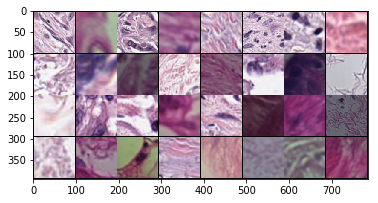

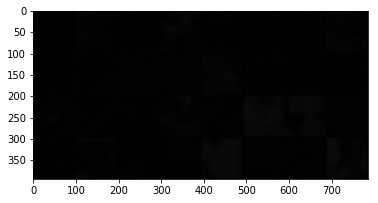

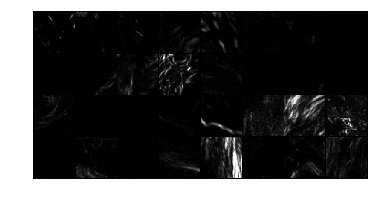

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


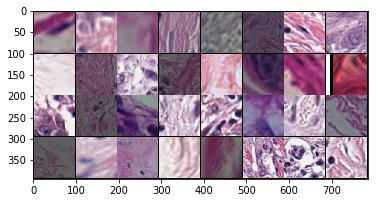

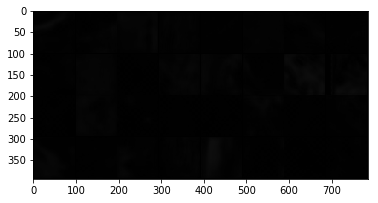

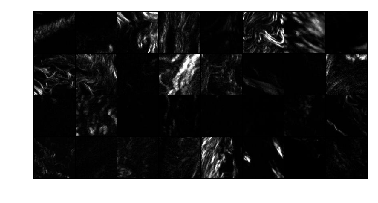

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


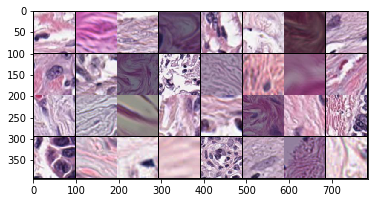

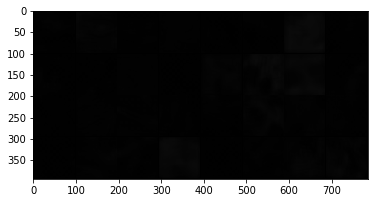

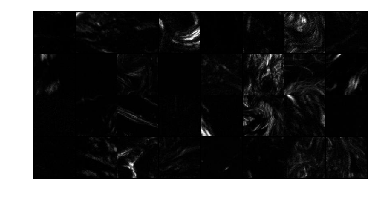

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


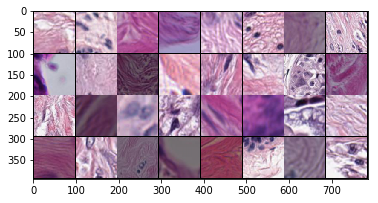

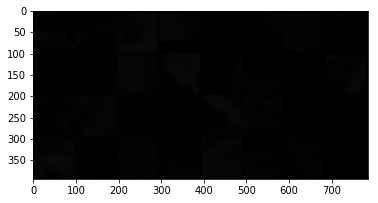

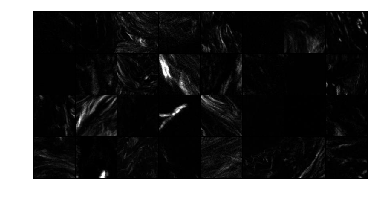

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


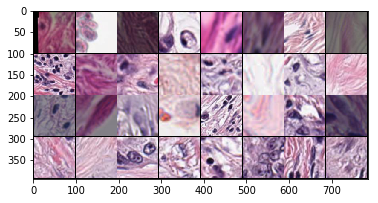

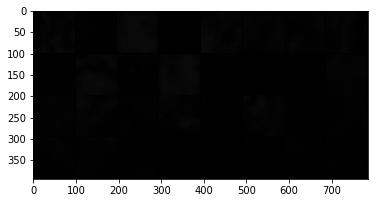

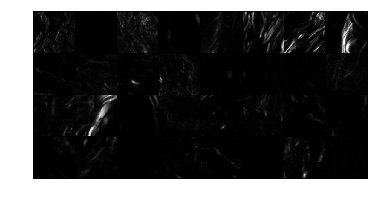

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


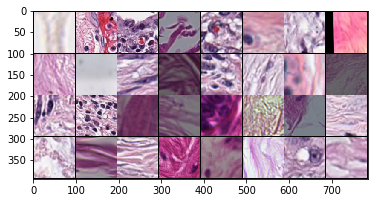

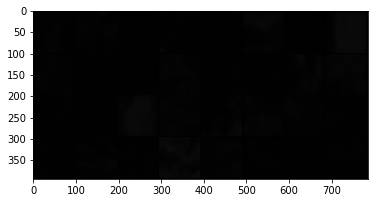

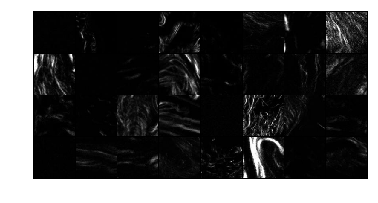

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


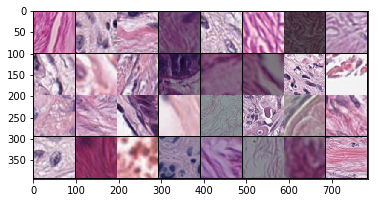

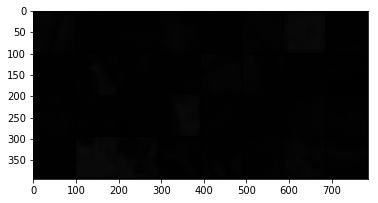

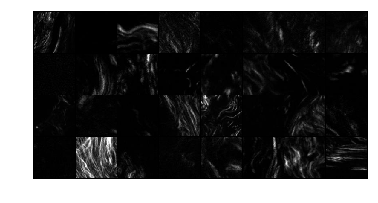

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


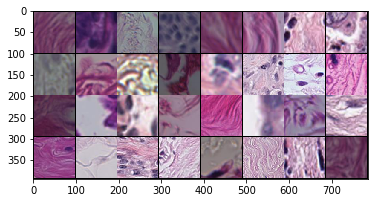

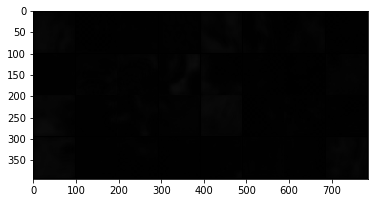

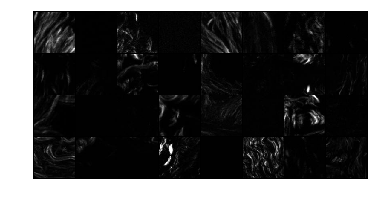

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


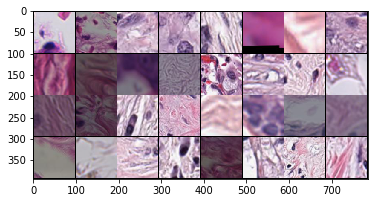

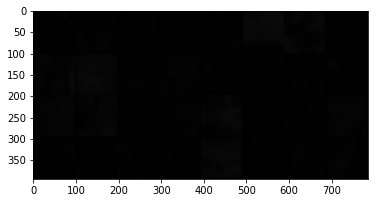

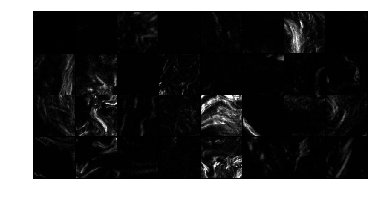

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


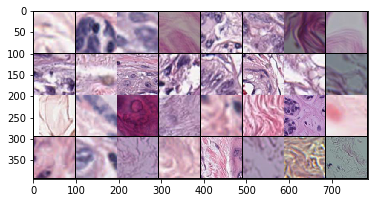

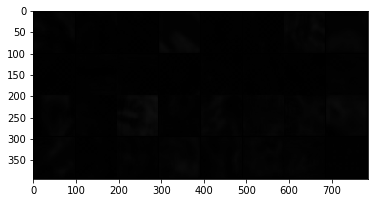

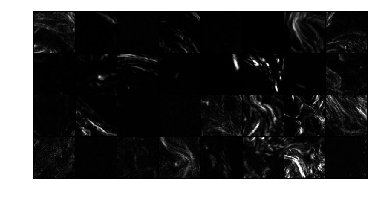

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


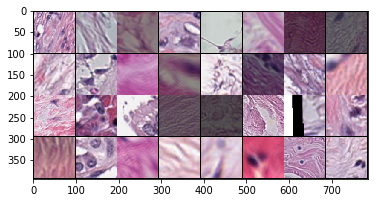

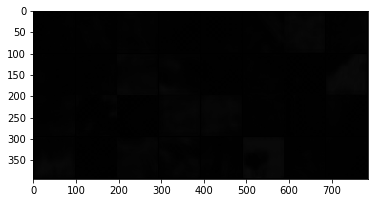

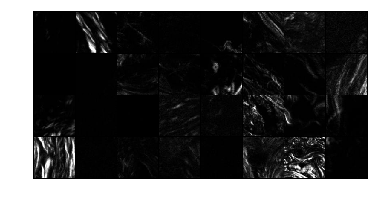

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


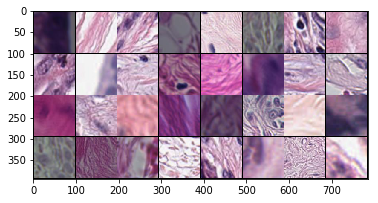

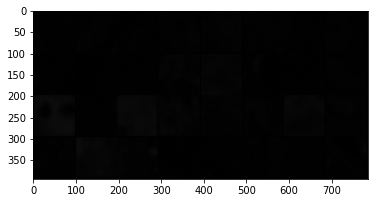

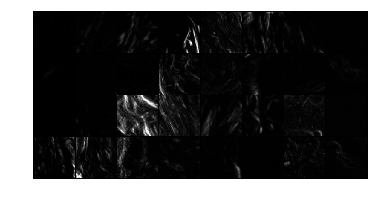

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


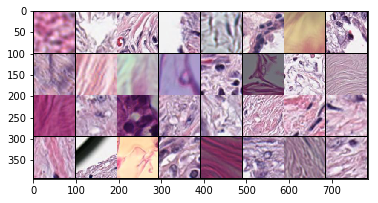

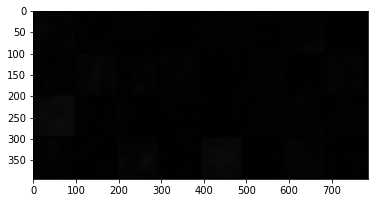

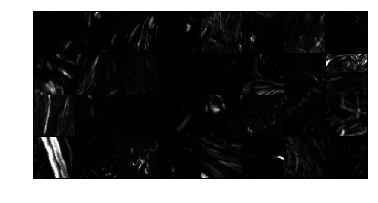

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


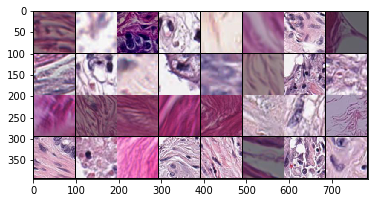

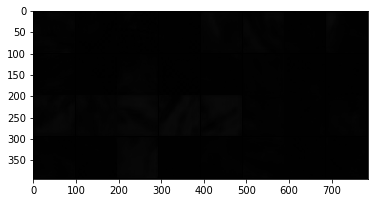

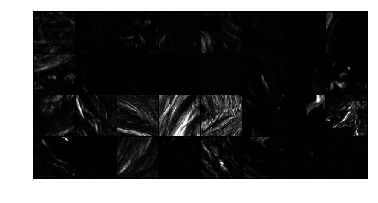

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


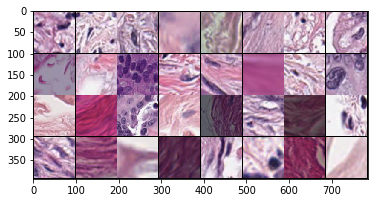

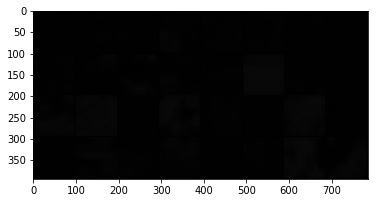

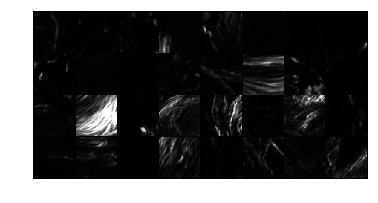

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


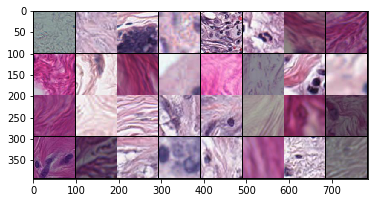

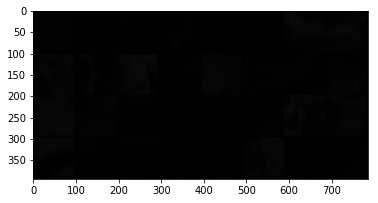

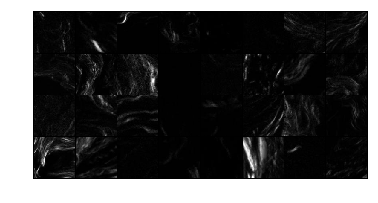

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


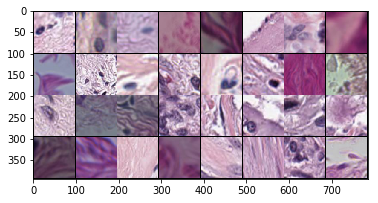

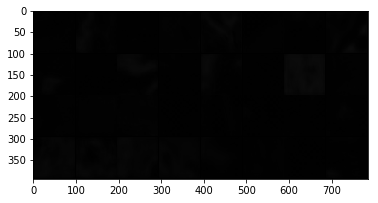

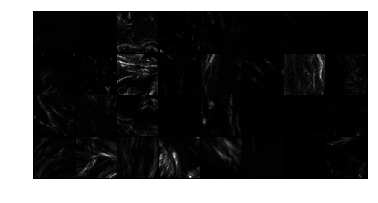

===> Avg. PSNR: nan dB


In [27]:
test()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
for epoch in range(1, 5 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

In [30]:
cwd = os.getcwd();
path = os.path.join(cwd, 'Saved model', 'cnnshuffle.pth')
torch.save(model.state_dict(), path)

In [ ]:
model.load_state_dict(torch.load(path))
model.eval()

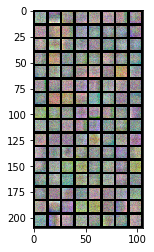

In [28]:
from torchvision.utils import make_grid
kernels = model.block0[1].weight.detach().clone().cpu()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
img = make_grid(kernels)
plt.imshow(img.permute(1, 2, 0))